## Import library 

In [28]:
!pip install torchsummary

In [29]:
import random
import os
import gc

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.inspection import permutation_importance
from sklearn.utils import shuffle
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score , classification_report,f1_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import TensorDataset
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim import Adam
from torchsummary import summary
import torch.backends.cudnn as cudnn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

from PIL import Image

import timm
from collections import Counter

## Config


## <span style="color: red">torch_seed must be run as needed to ensure reproducibility</span>

In [73]:
class CFG:
    def __init__(self):
        
        self.root="/kaggle/input/brain-mri-images-for-brain-tumor-detection"

        self.seed=777
        self.epochs=10
        self.batch_size=[4,8,16]
        self.learning_rate=0.00001
        self.input_class=None
        self.output_class=2
        self.img_size=256

        self.device=torch.device("cuda:0"if torch.cuda.is_available() else "cpu")

        self.class_mapping = {
            "no":0,
            'yes':1,
        }
        
        self.hypara={
            "fc1_out":[64,2048],
            "learning_rate":[1e-5,1e-2],
            "batch_size":self.batch_size}
        

config=CFG()

# fix seed
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

def torch_seed(seed=config.seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms=True
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False
    g = torch.Generator()
    g.manual_seed(seed)

torch_seed()

## Load data

## Train

In [31]:
def Load(dir):
    filepaths=[]
    labels=[]
    
    folds=os.listdir(dir)
    folds=folds[:-1]
    #folds=[file for file in folds if not file.endswith(('.md', '.csv'))]
    
    for fold in folds:
        foldpath=os.path.join(dir,fold)
        filelist=os.listdir(foldpath)
        
        for file in filelist:
            path=os.path.join(foldpath,file)
            filepaths.append(path)
            labels.append(fold)
    
    X=pd.Series(filepaths,name="filepaths")
    y=pd.Series(labels,name="labels")
    df=pd.concat([X,y],axis=1)
    
    return df

data=Load(config.root)

In [32]:
data.head()

,filepaths,labels
0,/kaggle/input/brain-mri-images-for-brain-tumor...,no
1,/kaggle/input/brain-mri-images-for-brain-tumor...,no
2,/kaggle/input/brain-mri-images-for-brain-tumor...,no
3,/kaggle/input/brain-mri-images-for-brain-tumor...,no
4,/kaggle/input/brain-mri-images-for-brain-tumor...,no


# Show data

In [33]:
# def Show(train_df,test_df,val_df):
#     fig,axs=plt.subplots(1,3,figsize=(15,5))

#     for i,(name,df) in enumerate(zip(["train","test","val"],[train_df,test_df,val_df])):
#         label_counts=df["labels"].value_counts()
#         axs[i].bar(label_counts.index,label_counts.values)
#         axs[i].set_title(name)
#         axs[i].set_xlabel('Labels')
#         axs[i].set_ylabel('Count')
#         axs[i].tick_params(axis='x', rotation=0)

#     plt.tight_layout()
#     plt.show()

# print(train_df["labels"].value_counts())
# Show(train_df,test_df,val_df)

# Processing

In [34]:
# Normal -> 0 , Pneumonia -> 1
def encode(df):
    df["labels"]=df["labels"].map(config.class_mapping)

encode(data)

In [35]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
img_size=config.img_size


transform = transforms.Compose([
                                transforms.Resize((img_size,img_size)),
                                transforms.Grayscale(num_output_channels=3),  
                                transforms.RandomRotation(10), 
                                transforms.RandomHorizontalFlip(p=0.4), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums,std=std_nums)
                                ])

test_transform = transforms.Compose([
                                transforms.Resize((img_size,img_size)),
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums,std=std_nums)
                                ])

# Transform Image

In [36]:
class ImageDataset(Dataset):

    def __init__(self,filepaths,labels,transform=None):
        self.filepaths=filepaths
        self.labels=labels
        self.transform=transform
    
    def __getitem__(self,index):
        torch_seed()
        img=Image.open(self.filepaths[index])
        if self.transform is not None:
            img=self.transform(img)
        label=self.labels[index]
        return img,label
    
    def __len__(self):
        return len(self.labels)


dataset=ImageDataset(data["filepaths"],data["labels"],transform)

train_valid,test=train_test_split(dataset,test_size=0.2,random_state=config.seed)
train,valid=train_test_split(train_valid,test_size=0.25,random_state=config.seed)

# Make dataloader

In [37]:
def make_dataloader(data,batch_sizes=None,shuffle=True):
    all_dataloader={}
    
    if batch_sizes!=None:
        for batch_size in batch_sizes:
            dataloader=DataLoader(data,batch_size=batch_size,worker_init_fn=worker_init_fn,shuffle=shuffle)
            all_dataloader[batch_size]=dataloader
        return all_dataloader
    else:
        dataloader=DataLoader(data,worker_init_fn=worker_init_fn,shuffle=shuffle)
        return dataloader


In [38]:
all_train_dataloader=make_dataloader(train,config.batch_size)
all_valid_dataloader=make_dataloader(valid,config.batch_size,shuffle=False)
test_dataloader=make_dataloader(test,shuffle=False)
all_train_dataloader

{4: <torch.utils.data.dataloader.DataLoader at 0x7c8b3a303550>,
 8: <torch.utils.data.dataloader.DataLoader at 0x7c8b3a301450>,
 16: <torch.utils.data.dataloader.DataLoader at 0x7c8b3a300400>}

# Best model by Optuna

In [62]:
## save hyper parameters found by optuna
def save_params(name,params):
    file_name = f"{name}.txt"

    with open(file_name, 'w') as file:
        for key, value in params.items():
            file.write(f"{key}: {value}\n")

## save model
def save_model(name,model):
    model_scripted = torch.jit.script(model)
    file_name=f"{name}.pth"
    model_scripted.save(file_name)

# clear cuda memory
def clear():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.memory_allocated()

# plot train and eval result
def plot_result(loss_list,val_loss_list,val_acc_list,cm):
    plt.plot(loss_list,label="train_loss")
    plt.plot(val_loss_list,label="val_loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")

    plt.figure()
    plt.plot(val_acc_list,label="val_acc")
    plt.legend()
    plt.ylim(0.5,1)
    plt.xlabel("epoch")
    plt.ylabel("acc")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [56]:
def train(model,optimizer,train_dataloader):
    criterion=nn.CrossEntropyLoss()
    loss_sum=0

    model.train()
    for X,y in train_dataloader:
        X,y=X.to(config.device),y.to(config.device)
        optimizer.zero_grad()
        pred=model(X)
        loss=criterion(pred,y)
        loss_sum+=loss.item()
        loss.backward()
        optimizer.step()
        # count=Counter(y.cpu().numpy())
        # print(count)

    train_loss=loss_sum/len(train_dataloader)

    return train_loss

def valid(model,valid_dataloader):
    criterion=nn.CrossEntropyLoss()
    loss_sum=0
    correct=0
    total=0

    model.eval()
    correct=0
    with torch.no_grad():
        for X,y in valid_dataloader:
            X,y=X.to(config.device),y.to(config.device)
            pred=model(X)
            loss=criterion(pred,y)
            loss_sum+=loss.item()
            pred=pred.max(1, keepdim=True)[1]
            correct+=pred.eq(y.view_as(pred)).sum().item()
            total+=y.size(0)
            #count=Counter(y.cpu().numpy())
            #print(count)
    
    val_loss=loss_sum/len(valid_dataloader)
    val_acc=correct/total
    return val_loss,val_acc

def test(model,test_data):
    correct=0
    total=0
    y_true=[]
    y_pred=[]

    model.eval()
    correct=0
    with torch.no_grad():
        for X,y in test_data:
            X,y=X.to(config.device),y.to(config.device)
            pred=model(X)
            pred=pred.max(1, keepdim=True)[1]
            
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
            correct+=pred.eq(y.view_as(pred)).sum().item()
            total+=y.size(0)
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    test_acc=correct/total
    return test_acc,cm,y_pred

In [92]:
# customed optuna
def exe_optuna(hypara,Model,pretrained=False,show_result=True):
    
    def objective_custom():

        def objective(trial):
            clear()
            torch_seed()

            epochs=config.epochs

            if not pretrained:
                fc1_out=trial.suggest_int("fc1_out",hypara["fc1_out"][0],hypara["fc1_out"][1])

            learning_rate=trial.suggest_float("learning_rate",hypara["learning_rate"][0],hypara["learning_rate"][1])
            barch_size=trial.suggest_categorical("batch_size",hypara["batch_size"])

            if not pretrained:
                model=Model(fc1_out).to(device=config.device)
            else:
                model=timm.create_model(Model,pretrained=True,num_classes=2).to(config.device)

            optimizer=Adam(model.parameters(),lr=learning_rate)

            torch_seed()

            for epoch in range(epochs):
                loss=train(model,optimizer,all_train_dataloader[barch_size])
                val_loss,val_acc=valid(model,all_valid_dataloader[barch_size])
                if show_result:
                    print(f"train loss : {loss:.4f}  val_loss : {val_loss:.4f}  val_acc : {val_acc:.4f} ")

            return val_loss

        return objective
    
    study = optuna.create_study()
    study.optimize(objective_custom(),n_trials=30)

    best_params = study.best_params
    print("Best Hyperparameters:", best_params)

    save_params(f"{Model}",best_params)
    
    return best_params


# execute best model  
def exe_best_model(best_hypara,Model,pretrained=False):
    clear()
    torch_seed()

    loss_list=[]
    val_loss_list=[]
    val_acc_list=[]

    epochs=config.epochs
    if not pretrained:
        fc1_out=best_hypara["fc1_out"]
    learning_rate=best_hypara["learning_rate"]
    batch_size=best_hypara["batch_size"]
    
    if pretrained:
        print(f"learning rate : {learning_rate}  batch size : {batch_size}")
        model=timm.create_model(Model,pretrained=True,num_classes=2).to(config.device)
        optimizer=Adam(model.parameters(),lr=learning_rate)
    else:
        print(f"fc1 out : {fc1_out}  learning rate : {learning_rate}  batch size : {batch_size}")
        model=Model(fc1_out).to(device=config.device)
        optimizer=Adam(model.parameters(),lr=learning_rate)

    torch_seed()

    for epoch in range(epochs):
        loss=train(model,optimizer,all_train_dataloader[batch_size])
        val_loss,val_acc=valid(model,all_valid_dataloader[batch_size])
        print(f"train loss : {loss:.4f}  val_loss : {val_loss:.4f}  val_acc : {val_acc:.4f} ")
        loss_list.append(loss)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

    test_acc,cm,pred=test(model,test_dataloader)
    print(f"test accuracy : {test_acc}")
#     f_score=f1_score(pred,test_df["labels"])
#     print(f"f1 score : {f_score}")

#     save_model(f"best_{test_acc}",model)

    plot_result(loss_list,val_loss_list,val_acc_list,cm)

# CNN ( 5 layers )

In [ ]:
class CNN_5(nn.Module):

    def __init__(self,fc1_out=1):
        super().__init__()
        self.relu=nn.ReLU()
        self.pool=nn.MaxPool2d(2,stride=2)
        self.dropout1=nn.Dropout(0.1)
        self.dropout2=nn.Dropout(0.2)
        
        self.conv1=nn.Conv2d(3,16,kernel_size=3)
        self.conv2=nn.Conv2d(16,32,kernel_size=3)
        self.conv3=nn.Conv2d(32,64,kernel_size=3)

        self.fc1=nn.Linear(64*30*30,fc1_out)
        self.fc2=nn.Linear(fc1_out,2)

    def forward(self,x):
        x=self.conv1(x)
        x-self.relu(x)
        x=self.pool(x)

        x=self.conv2(x)
        x=self.dropout1(x)
        x=self.relu(x)
        x=self.pool(x)

        x=self.conv3(x)
        x=self.dropout2(x)
        x=self.relu(x)
        x=self.pool(x)

        x=x.view(x.size()[0],-1)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        
        return x

# # show exsample of model
# CNN=Model(2048).to(config.device)
# summary(CNN,(3,256,256))    # summary(model,(channel,size,size))

## Find best hyper parameters of CNN (5 layers)

In [79]:
best_params=exe_optuna(config.hypara,CNN_5,pretrained=False,show_result=False)

[I 2024-04-15 05:25:30,953] A new study created in memory with name: no-name-a734b20c-bb7b-4bbe-bba1-342711953a53
[I 2024-04-15 05:25:36,460] Trial 0 finished with value: 0.743489995598793 and parameters: {'fc1_out': 1790, 'learning_rate': 0.007042467044736161, 'batch_size': 16}. Best is trial 0 with value: 0.743489995598793.
[I 2024-04-15 05:25:41,646] Trial 1 finished with value: 0.7440322786569595 and parameters: {'fc1_out': 1578, 'learning_rate': 0.005551494174751608, 'batch_size': 16}. Best is trial 0 with value: 0.743489995598793.
[I 2024-04-15 05:25:44,828] Trial 2 finished with value: 0.8309157221644584 and parameters: {'fc1_out': 174, 'learning_rate': 0.0006140048741660455, 'batch_size': 8}. Best is trial 0 with value: 0.743489995598793.
[I 2024-04-15 05:25:55,324] Trial 3 finished with value: 0.715290904045105 and parameters: {'fc1_out': 1789, 'learning_rate': 0.00540001425136673, 'batch_size': 4}. Best is trial 3 with value: 0.715290904045105.
[I 2024-04-15 05:25:59,786] Tri

Best Hyperparameters: {'fc1_out': 1356, 'learning_rate': 2.3396624797953877e-05, 'batch_size': 4}


## Best model of CNN (5 layers)

fc1 out : 1356  learning rate : 2.3396624797953877e-05  batch size : 4
train loss : 0.6791  val_loss : 0.5603  val_acc : 0.8627 
train loss : 0.5079  val_loss : 0.5950  val_acc : 0.7647 
train loss : 0.4148  val_loss : 0.4636  val_acc : 0.8627 
train loss : 0.3732  val_loss : 0.4461  val_acc : 0.8824 
train loss : 0.2958  val_loss : 0.4320  val_acc : 0.9020 
train loss : 0.2508  val_loss : 0.4623  val_acc : 0.8824 
train loss : 0.2147  val_loss : 0.4212  val_acc : 0.8824 
train loss : 0.1548  val_loss : 0.4128  val_acc : 0.9216 
train loss : 0.1282  val_loss : 0.4781  val_acc : 0.9216 
train loss : 0.1045  val_loss : 0.4723  val_acc : 0.9216 
test accuracy : 0.803921568627451


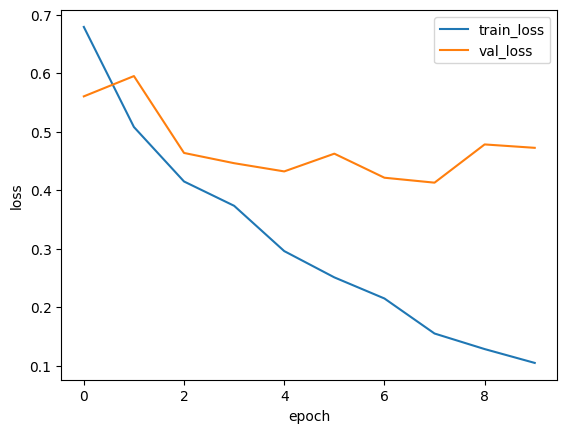

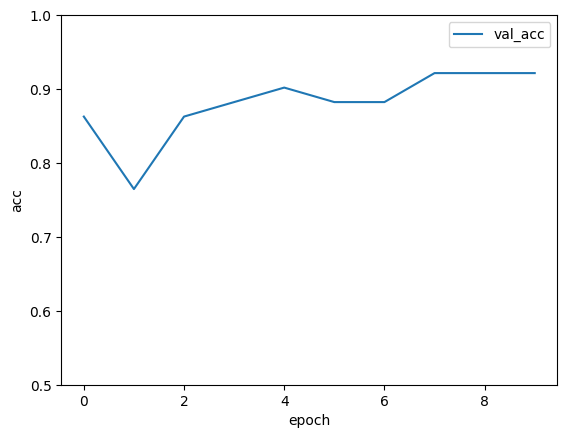

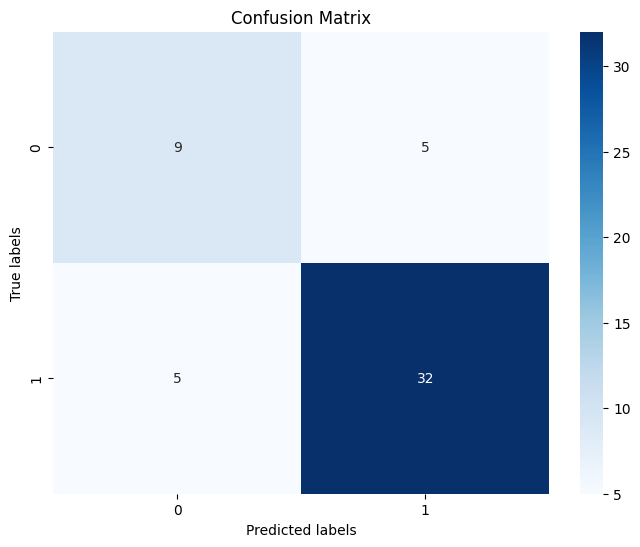

In [80]:
exe_best_model(best_params,CNN_5,pretrained=False)

# CNN (7 layers)

In [81]:
class CNN_7(nn.Module):

    def __init__(self,fc1_out):
        super().__init__()
        self.relu=nn.ReLU()
        self.pool=nn.MaxPool2d(2,stride=2)
        self.dropout1=nn.Dropout(0.1)
        self.dropout2=nn.Dropout(0.2)
        
        self.conv1=nn.Conv2d(3,32,kernel_size=3)
        self.conv2=nn.Conv2d(32,64,kernel_size=3)
        self.conv3=nn.Conv2d(64,64,kernel_size=3)
        self.conv4=nn.Conv2d(64,128,kernel_size=3)
        self.conv5=nn.Conv2d(128,256,kernel_size=3)

        self.fc1=nn.Linear(256*6*6,fc1_out)
        self.fc2=nn.Linear(fc1_out,2)

    def forward(self,x):
        x=self.conv1(x)
        x-self.relu(x)
        x=self.pool(x)

        x=self.conv2(x)
        x=self.relu(x)
        x=self.pool(x)

        x=self.conv3(x)
        x=self.dropout1(x)
        x=self.relu(x)
        x=self.pool(x)

        x=self.conv4(x)
        x=self.dropout2(x)
        x=self.relu(x)
        x=self.pool(x)

        x=self.conv5(x)
        x=self.relu(x)
        x=self.pool(x)

        x=x.view(x.size()[0],-1)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        
        return x

# show exsample of model
CNN=Model(2048).to(config.device)
summary(CNN,(3,256,256))    # summary(model,(channel,size,size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
              ReLU-2         [-1, 16, 254, 254]               0
         MaxPool2d-3         [-1, 16, 127, 127]               0
            Conv2d-4         [-1, 32, 125, 125]           4,640
           Dropout-5         [-1, 32, 125, 125]               0
              ReLU-6         [-1, 32, 125, 125]               0
         MaxPool2d-7           [-1, 32, 62, 62]               0
            Conv2d-8           [-1, 64, 60, 60]          18,496
           Dropout-9           [-1, 64, 60, 60]               0
             ReLU-10           [-1, 64, 60, 60]               0
        MaxPool2d-11           [-1, 64, 30, 30]               0
           Linear-12                 [-1, 2048]     117,966,848
             ReLU-13                 [-1, 2048]               0
           Linear-14                   

## Find best hyper parameters of CNN (7 layers)

In [82]:
exe_optuna(config.hypara,CNN_7,pretrained=False)

[I 2024-04-15 05:39:06,762] A new study created in memory with name: no-name-5128bd55-d90a-45a0-8271-737240863473


train loss : 0.7272  val_loss : 0.6789  val_acc : 0.5098 
train loss : 0.6847  val_loss : 0.6906  val_acc : 0.5098 
train loss : 0.6722  val_loss : 0.6324  val_acc : 0.8039 
train loss : 0.6596  val_loss : 0.6774  val_acc : 0.5490 
train loss : 0.6745  val_loss : 0.6960  val_acc : 0.5098 
train loss : 0.6350  val_loss : 0.6494  val_acc : 0.5686 
train loss : 0.6038  val_loss : 0.5333  val_acc : 0.7059 
train loss : 0.5453  val_loss : 0.5126  val_acc : 0.8039 
train loss : 0.4833  val_loss : 0.6053  val_acc : 0.7255 


[I 2024-04-15 05:39:11,799] Trial 0 finished with value: 0.4946117057250096 and parameters: {'fc1_out': 1211, 'learning_rate': 0.0008100149589924103, 'batch_size': 4}. Best is trial 0 with value: 0.4946117057250096.


train loss : 0.5345  val_loss : 0.4946  val_acc : 0.8431 
train loss : 1.5426  val_loss : 0.7512  val_acc : 0.5098 
train loss : 0.6901  val_loss : 0.7346  val_acc : 0.5098 
train loss : 0.6434  val_loss : 0.6927  val_acc : 0.5490 
train loss : 0.6038  val_loss : 0.6484  val_acc : 0.7255 
train loss : 0.5625  val_loss : 0.6925  val_acc : 0.6078 
train loss : 0.5711  val_loss : 0.8645  val_acc : 0.5882 
train loss : 0.5520  val_loss : 0.7711  val_acc : 0.6078 
train loss : 0.4999  val_loss : 0.9538  val_acc : 0.5686 
train loss : 0.4794  val_loss : 0.6833  val_acc : 0.7255 


[I 2024-04-15 05:39:15,379] Trial 1 finished with value: 0.5703321062028408 and parameters: {'fc1_out': 1899, 'learning_rate': 0.004086656825568871, 'batch_size': 16}. Best is trial 0 with value: 0.4946117057250096.


train loss : 0.5013  val_loss : 0.5703  val_acc : 0.8039 
train loss : 0.9384  val_loss : 0.7119  val_acc : 0.5098 
train loss : 0.6823  val_loss : 0.7142  val_acc : 0.5098 
train loss : 0.6697  val_loss : 0.6935  val_acc : 0.4902 
train loss : 0.6933  val_loss : 0.6950  val_acc : 0.5098 
train loss : 0.6750  val_loss : 0.7115  val_acc : 0.5098 
train loss : 0.6766  val_loss : 0.7126  val_acc : 0.5098 
train loss : 0.6749  val_loss : 0.7080  val_acc : 0.5098 
train loss : 0.6689  val_loss : 0.7154  val_acc : 0.5098 
train loss : 0.6728  val_loss : 0.7210  val_acc : 0.5098 


[I 2024-04-15 05:39:19,178] Trial 2 finished with value: 0.7178677661078317 and parameters: {'fc1_out': 156, 'learning_rate': 0.004587075863025067, 'batch_size': 8}. Best is trial 0 with value: 0.4946117057250096.


train loss : 0.6709  val_loss : 0.7179  val_acc : 0.5098 
train loss : 20.9456  val_loss : 10.3640  val_acc : 0.5882 
train loss : 4.6572  val_loss : 0.6908  val_acc : 0.4902 
train loss : 0.8519  val_loss : 0.6966  val_acc : 0.5098 
train loss : 0.6753  val_loss : 0.7034  val_acc : 0.5098 
train loss : 0.6711  val_loss : 0.7086  val_acc : 0.5098 
train loss : 0.6720  val_loss : 0.7136  val_acc : 0.5098 
train loss : 0.6723  val_loss : 0.7116  val_acc : 0.5098 
train loss : 0.6693  val_loss : 0.7124  val_acc : 0.5098 
train loss : 0.6709  val_loss : 0.7151  val_acc : 0.5098 


[I 2024-04-15 05:39:23,505] Trial 3 finished with value: 0.7159537764695975 and parameters: {'fc1_out': 261, 'learning_rate': 0.007895652500488624, 'batch_size': 4}. Best is trial 0 with value: 0.4946117057250096.


train loss : 0.6709  val_loss : 0.7160  val_acc : 0.5098 
train loss : 183.9758  val_loss : 0.7039  val_acc : 0.4902 
train loss : 0.8628  val_loss : 0.7017  val_acc : 0.5098 
train loss : 0.6751  val_loss : 0.7108  val_acc : 0.5098 
train loss : 0.6714  val_loss : 0.7108  val_acc : 0.5098 
train loss : 0.6714  val_loss : 0.7121  val_acc : 0.5098 
train loss : 0.6740  val_loss : 0.7139  val_acc : 0.5098 
train loss : 0.6759  val_loss : 0.7213  val_acc : 0.5098 
train loss : 0.6716  val_loss : 0.7200  val_acc : 0.5098 
train loss : 0.6751  val_loss : 0.7118  val_acc : 0.5098 


[I 2024-04-15 05:39:28,999] Trial 4 finished with value: 0.716318781559284 and parameters: {'fc1_out': 1995, 'learning_rate': 0.009532537497397226, 'batch_size': 4}. Best is trial 0 with value: 0.4946117057250096.


train loss : 0.6721  val_loss : 0.7163  val_acc : 0.5098 
train loss : 0.6877  val_loss : 0.6854  val_acc : 0.5098 
train loss : 0.5894  val_loss : 0.7868  val_acc : 0.7451 
train loss : 0.5350  val_loss : 0.5988  val_acc : 0.8039 
train loss : 0.4721  val_loss : 0.6150  val_acc : 0.7647 
train loss : 0.3791  val_loss : 0.4884  val_acc : 0.7843 
train loss : 0.3751  val_loss : 0.8870  val_acc : 0.7255 
train loss : 0.3915  val_loss : 0.5389  val_acc : 0.8824 
train loss : 0.2372  val_loss : 0.6500  val_acc : 0.7843 
train loss : 0.1463  val_loss : 1.1500  val_acc : 0.8039 


[I 2024-04-15 05:39:33,181] Trial 5 finished with value: 1.072907275387219 and parameters: {'fc1_out': 1258, 'learning_rate': 0.00021148625409387155, 'batch_size': 8}. Best is trial 0 with value: 0.4946117057250096.


train loss : 0.1109  val_loss : 1.0729  val_acc : 0.8039 
train loss : 22.4022  val_loss : 0.6981  val_acc : 0.5098 
train loss : 0.6821  val_loss : 0.7393  val_acc : 0.5098 
train loss : 0.6761  val_loss : 0.6973  val_acc : 0.5098 
train loss : 0.6816  val_loss : 0.7188  val_acc : 0.5098 
train loss : 0.6681  val_loss : 0.7236  val_acc : 0.5098 
train loss : 0.6728  val_loss : 0.7340  val_acc : 0.5098 
train loss : 0.6780  val_loss : 0.7714  val_acc : 0.5098 
train loss : 0.6820  val_loss : 0.7107  val_acc : 0.5098 
train loss : 0.6640  val_loss : 0.7380  val_acc : 0.5098 


[I 2024-04-15 05:39:36,535] Trial 6 finished with value: 0.7448190152645111 and parameters: {'fc1_out': 1460, 'learning_rate': 0.006141462700024476, 'batch_size': 16}. Best is trial 0 with value: 0.4946117057250096.


train loss : 0.6781  val_loss : 0.7448  val_acc : 0.5098 
train loss : 0.8370  val_loss : 0.6939  val_acc : 0.4118 
train loss : 0.6899  val_loss : 0.6944  val_acc : 0.5098 
train loss : 0.6830  val_loss : 0.6985  val_acc : 0.5098 
train loss : 0.6754  val_loss : 0.7043  val_acc : 0.5098 
train loss : 0.6708  val_loss : 0.7100  val_acc : 0.5098 
train loss : 0.6707  val_loss : 0.7188  val_acc : 0.5098 
train loss : 0.6709  val_loss : 0.7164  val_acc : 0.5098 
train loss : 0.6691  val_loss : 0.7162  val_acc : 0.5098 
train loss : 0.6692  val_loss : 0.7222  val_acc : 0.5098 


[I 2024-04-15 05:39:40,797] Trial 7 finished with value: 0.7229382480893817 and parameters: {'fc1_out': 1493, 'learning_rate': 0.0021740773106404443, 'batch_size': 8}. Best is trial 0 with value: 0.4946117057250096.


train loss : 0.6701  val_loss : 0.7229  val_acc : 0.5098 
train loss : 28.7300  val_loss : 0.7003  val_acc : 0.5098 
train loss : 0.6944  val_loss : 0.6944  val_acc : 0.5098 
train loss : 0.6785  val_loss : 0.7091  val_acc : 0.5098 
train loss : 0.6704  val_loss : 0.7101  val_acc : 0.5098 
train loss : 0.6709  val_loss : 0.7112  val_acc : 0.5098 
train loss : 0.6724  val_loss : 0.7144  val_acc : 0.5098 
train loss : 0.6734  val_loss : 0.7132  val_acc : 0.5098 
train loss : 0.6698  val_loss : 0.7142  val_acc : 0.5098 
train loss : 0.6718  val_loss : 0.7156  val_acc : 0.5098 


[I 2024-04-15 05:39:45,546] Trial 8 finished with value: 0.7161562396929815 and parameters: {'fc1_out': 887, 'learning_rate': 0.007922650131402939, 'batch_size': 4}. Best is trial 0 with value: 0.4946117057250096.


train loss : 0.6711  val_loss : 0.7162  val_acc : 0.5098 
train loss : 0.6675  val_loss : 0.6788  val_acc : 0.5098 
train loss : 0.5821  val_loss : 0.7340  val_acc : 0.6275 
train loss : 0.5044  val_loss : 0.5694  val_acc : 0.8627 
train loss : 0.4650  val_loss : 0.5528  val_acc : 0.8627 
train loss : 0.4065  val_loss : 0.5105  val_acc : 0.8627 
train loss : 0.3685  val_loss : 0.6641  val_acc : 0.8235 
train loss : 0.4080  val_loss : 0.6330  val_acc : 0.7843 
train loss : 0.3264  val_loss : 0.5475  val_acc : 0.8824 
train loss : 0.2396  val_loss : 0.5853  val_acc : 0.8824 


[I 2024-04-15 05:39:49,605] Trial 9 finished with value: 0.6978270571146693 and parameters: {'fc1_out': 1010, 'learning_rate': 0.00010118399791828862, 'batch_size': 8}. Best is trial 0 with value: 0.4946117057250096.


train loss : 0.2078  val_loss : 0.6978  val_acc : 0.8431 
train loss : 0.9799  val_loss : 0.6931  val_acc : 0.5098 
train loss : 0.6844  val_loss : 0.6947  val_acc : 0.5098 
train loss : 0.6788  val_loss : 0.6997  val_acc : 0.5098 
train loss : 0.6722  val_loss : 0.7041  val_acc : 0.5098 
train loss : 0.6710  val_loss : 0.7076  val_acc : 0.5098 
train loss : 0.6714  val_loss : 0.7125  val_acc : 0.5098 
train loss : 0.6713  val_loss : 0.7114  val_acc : 0.5098 
train loss : 0.6692  val_loss : 0.7116  val_acc : 0.5098 
train loss : 0.6702  val_loss : 0.7148  val_acc : 0.5098 


[I 2024-04-15 05:39:54,174] Trial 10 finished with value: 0.7159126378022708 and parameters: {'fc1_out': 625, 'learning_rate': 0.0019259731634701086, 'batch_size': 4}. Best is trial 0 with value: 0.4946117057250096.


train loss : 0.6706  val_loss : 0.7159  val_acc : 0.5098 
train loss : 36.4506  val_loss : 0.7575  val_acc : 0.5098 
train loss : 0.6951  val_loss : 0.7006  val_acc : 0.5098 
train loss : 0.6846  val_loss : 0.7239  val_acc : 0.5098 
train loss : 0.6697  val_loss : 0.7077  val_acc : 0.5098 
train loss : 0.6672  val_loss : 0.7304  val_acc : 0.5098 
train loss : 0.6761  val_loss : 0.7227  val_acc : 0.5098 
train loss : 0.6794  val_loss : 0.7055  val_acc : 0.5098 
train loss : 0.6643  val_loss : 0.7202  val_acc : 0.5098 
train loss : 0.6667  val_loss : 0.7471  val_acc : 0.5098 


[I 2024-04-15 05:39:57,735] Trial 11 finished with value: 0.7281540483236313 and parameters: {'fc1_out': 2000, 'learning_rate': 0.00418159221778631, 'batch_size': 16}. Best is trial 0 with value: 0.4946117057250096.


train loss : 0.6764  val_loss : 0.7282  val_acc : 0.5098 
train loss : 1.0130  val_loss : 0.7077  val_acc : 0.5098 
train loss : 0.6772  val_loss : 0.7229  val_acc : 0.5098 
train loss : 0.6775  val_loss : 0.7051  val_acc : 0.5098 
train loss : 0.6765  val_loss : 0.7029  val_acc : 0.5098 
train loss : 0.6670  val_loss : 0.7405  val_acc : 0.5098 
train loss : 0.6778  val_loss : 0.7168  val_acc : 0.5098 
train loss : 0.6797  val_loss : 0.7055  val_acc : 0.5098 
train loss : 0.6620  val_loss : 0.7331  val_acc : 0.5098 
train loss : 0.6738  val_loss : 0.7383  val_acc : 0.5098 


[I 2024-04-15 05:40:01,232] Trial 12 finished with value: 0.7204171866178513 and parameters: {'fc1_out': 1723, 'learning_rate': 0.0025471213278681435, 'batch_size': 16}. Best is trial 0 with value: 0.4946117057250096.


train loss : 0.6740  val_loss : 0.7204  val_acc : 0.5098 
train loss : 14.4086  val_loss : 0.6742  val_acc : 0.6667 
train loss : 0.7018  val_loss : 0.7110  val_acc : 0.5098 
train loss : 0.6775  val_loss : 0.7187  val_acc : 0.5098 
train loss : 0.6684  val_loss : 0.7104  val_acc : 0.5098 
train loss : 0.6672  val_loss : 0.7233  val_acc : 0.5098 
train loss : 0.6744  val_loss : 0.7245  val_acc : 0.5098 
train loss : 0.6778  val_loss : 0.7070  val_acc : 0.5098 
train loss : 0.6645  val_loss : 0.7167  val_acc : 0.5098 
train loss : 0.6667  val_loss : 0.7378  val_acc : 0.5098 


[I 2024-04-15 05:40:04,446] Trial 13 finished with value: 0.7232664376497269 and parameters: {'fc1_out': 701, 'learning_rate': 0.0033417936608273312, 'batch_size': 16}. Best is trial 0 with value: 0.4946117057250096.


train loss : 0.6760  val_loss : 0.7233  val_acc : 0.5098 
train loss : 41.1809  val_loss : 0.7661  val_acc : 0.5098 
train loss : 0.7248  val_loss : 0.7023  val_acc : 0.5098 
train loss : 0.6833  val_loss : 0.7003  val_acc : 0.5098 
train loss : 0.6754  val_loss : 0.7100  val_acc : 0.5098 
train loss : 0.6671  val_loss : 0.7301  val_acc : 0.5098 
train loss : 0.6724  val_loss : 0.7446  val_acc : 0.5098 
train loss : 0.6735  val_loss : 0.7277  val_acc : 0.5098 
train loss : 0.6632  val_loss : 0.7233  val_acc : 0.5098 
train loss : 0.6626  val_loss : 0.7421  val_acc : 0.5098 


[I 2024-04-15 05:40:07,924] Trial 14 finished with value: 0.7446272820234299 and parameters: {'fc1_out': 1667, 'learning_rate': 0.006415119243294595, 'batch_size': 16}. Best is trial 0 with value: 0.4946117057250096.


train loss : 0.6767  val_loss : 0.7446  val_acc : 0.5098 
train loss : 0.8011  val_loss : 0.6901  val_acc : 0.5098 
train loss : 0.6963  val_loss : 0.6945  val_acc : 0.5098 
train loss : 0.6708  val_loss : 0.6784  val_acc : 0.5098 
train loss : 0.6947  val_loss : 0.5923  val_acc : 0.8039 
train loss : 0.6088  val_loss : 0.6254  val_acc : 0.6078 
train loss : 0.5623  val_loss : 0.5586  val_acc : 0.7843 
train loss : 0.5784  val_loss : 0.4921  val_acc : 0.8627 
train loss : 0.4734  val_loss : 0.5100  val_acc : 0.8627 
train loss : 0.4812  val_loss : 0.4634  val_acc : 0.8627 


[I 2024-04-15 05:40:12,918] Trial 15 finished with value: 0.37505122789969814 and parameters: {'fc1_out': 1242, 'learning_rate': 0.0012868053981992071, 'batch_size': 4}. Best is trial 15 with value: 0.37505122789969814.


train loss : 0.4142  val_loss : 0.3751  val_acc : 0.8431 
train loss : 0.7799  val_loss : 0.6841  val_acc : 0.5098 
train loss : 0.6911  val_loss : 0.6976  val_acc : 0.5098 
train loss : 0.6844  val_loss : 0.6803  val_acc : 0.5686 
train loss : 0.6804  val_loss : 0.6794  val_acc : 0.5098 
train loss : 0.6775  val_loss : 0.6949  val_acc : 0.5098 
train loss : 0.6179  val_loss : 0.5972  val_acc : 0.7255 
train loss : 0.6740  val_loss : 0.7033  val_acc : 0.5098 
train loss : 0.6680  val_loss : 0.5938  val_acc : 0.7451 
train loss : 0.6664  val_loss : 0.6568  val_acc : 0.6471 


[I 2024-04-15 05:40:17,910] Trial 16 finished with value: 0.45407692056435806 and parameters: {'fc1_out': 1274, 'learning_rate': 0.0011611956585645677, 'batch_size': 4}. Best is trial 15 with value: 0.37505122789969814.


train loss : 0.5851  val_loss : 0.4541  val_acc : 0.8431 
train loss : 0.8440  val_loss : 0.6756  val_acc : 0.5098 
train loss : 0.6930  val_loss : 0.6998  val_acc : 0.5098 
train loss : 0.6832  val_loss : 0.6922  val_acc : 0.5098 
train loss : 0.6567  val_loss : 0.6578  val_acc : 0.7647 
train loss : 0.6371  val_loss : 0.6263  val_acc : 0.5882 
train loss : 0.5450  val_loss : 0.6765  val_acc : 0.5098 
train loss : 0.5554  val_loss : 0.6032  val_acc : 0.7451 
train loss : 0.5198  val_loss : 0.5731  val_acc : 0.7647 
train loss : 0.4639  val_loss : 0.5153  val_acc : 0.8235 


[I 2024-04-15 05:40:22,873] Trial 17 finished with value: 0.7200366434856103 and parameters: {'fc1_out': 1249, 'learning_rate': 0.0015586892891077029, 'batch_size': 4}. Best is trial 15 with value: 0.37505122789969814.


train loss : 0.2926  val_loss : 0.7200  val_acc : 0.8235 
train loss : 1.2059  val_loss : 0.6930  val_acc : 0.5098 
train loss : 0.6906  val_loss : 0.6901  val_acc : 0.5098 
train loss : 0.6848  val_loss : 0.6921  val_acc : 0.5098 
train loss : 0.6944  val_loss : 0.6937  val_acc : 0.5098 
train loss : 0.6804  val_loss : 0.6962  val_acc : 0.5098 
train loss : 0.6757  val_loss : 0.7020  val_acc : 0.5098 
train loss : 0.6723  val_loss : 0.7052  val_acc : 0.5098 
train loss : 0.6694  val_loss : 0.7078  val_acc : 0.5098 
train loss : 0.6701  val_loss : 0.7124  val_acc : 0.5098 


[I 2024-04-15 05:40:27,414] Trial 18 finished with value: 0.7145758317067072 and parameters: {'fc1_out': 541, 'learning_rate': 0.003272280253092666, 'batch_size': 4}. Best is trial 15 with value: 0.37505122789969814.


train loss : 0.6705  val_loss : 0.7146  val_acc : 0.5098 
train loss : 0.7433  val_loss : 0.6852  val_acc : 0.5098 
train loss : 0.6876  val_loss : 0.6921  val_acc : 0.5098 
train loss : 0.6887  val_loss : 0.6640  val_acc : 0.5098 
train loss : 0.6536  val_loss : 0.6550  val_acc : 0.5098 
train loss : 0.6409  val_loss : 0.6496  val_acc : 0.5490 
train loss : 0.5750  val_loss : 0.6383  val_acc : 0.7647 
train loss : 0.5809  val_loss : 0.6098  val_acc : 0.7059 
train loss : 0.6002  val_loss : 0.4758  val_acc : 0.8039 
train loss : 0.5345  val_loss : 0.4907  val_acc : 0.8431 


[I 2024-04-15 05:40:32,163] Trial 19 finished with value: 0.4075512633873866 and parameters: {'fc1_out': 878, 'learning_rate': 0.0011287629284341683, 'batch_size': 4}. Best is trial 15 with value: 0.37505122789969814.


train loss : 0.4509  val_loss : 0.4076  val_acc : 0.8627 
train loss : 9.2118  val_loss : 0.7040  val_acc : 0.5098 
train loss : 0.7181  val_loss : 0.6971  val_acc : 0.5098 
train loss : 0.7335  val_loss : 0.6960  val_acc : 0.5098 
train loss : 0.6770  val_loss : 0.7086  val_acc : 0.5098 
train loss : 0.6712  val_loss : 0.7101  val_acc : 0.5098 
train loss : 0.6721  val_loss : 0.7145  val_acc : 0.5098 
train loss : 0.6729  val_loss : 0.7126  val_acc : 0.5098 
train loss : 0.6697  val_loss : 0.7133  val_acc : 0.5098 
train loss : 0.6714  val_loss : 0.7153  val_acc : 0.5098 


[I 2024-04-15 05:40:36,949] Trial 20 finished with value: 0.7159495674646817 and parameters: {'fc1_out': 855, 'learning_rate': 0.005296480736480335, 'batch_size': 4}. Best is trial 15 with value: 0.37505122789969814.


train loss : 0.6710  val_loss : 0.7159  val_acc : 0.5098 
train loss : 0.7861  val_loss : 0.6818  val_acc : 0.5098 
train loss : 0.6803  val_loss : 0.6932  val_acc : 0.5098 
train loss : 0.6834  val_loss : 0.6986  val_acc : 0.5098 
train loss : 0.6728  val_loss : 0.7055  val_acc : 0.5098 
train loss : 0.6708  val_loss : 0.7093  val_acc : 0.5098 
train loss : 0.6716  val_loss : 0.7141  val_acc : 0.5098 
train loss : 0.6719  val_loss : 0.7119  val_acc : 0.5098 
train loss : 0.6694  val_loss : 0.7120  val_acc : 0.5098 
train loss : 0.6705  val_loss : 0.7152  val_acc : 0.5098 


[I 2024-04-15 05:40:41,874] Trial 21 finished with value: 0.7160944801110488 and parameters: {'fc1_out': 1159, 'learning_rate': 0.0009881219609675094, 'batch_size': 4}. Best is trial 15 with value: 0.37505122789969814.


train loss : 0.6707  val_loss : 0.7161  val_acc : 0.5098 
train loss : 0.8458  val_loss : 0.6799  val_acc : 0.5098 
train loss : 0.6914  val_loss : 0.7018  val_acc : 0.5098 
train loss : 0.6671  val_loss : 0.6644  val_acc : 0.6863 
train loss : 0.6359  val_loss : 0.5609  val_acc : 0.7647 
train loss : 0.5578  val_loss : 0.5864  val_acc : 0.7255 
train loss : 0.5106  val_loss : 0.5946  val_acc : 0.6667 
train loss : 0.5053  val_loss : 0.4173  val_acc : 0.8824 
train loss : 0.4682  val_loss : 0.5322  val_acc : 0.6667 
train loss : 0.4620  val_loss : 0.5583  val_acc : 0.7843 


[I 2024-04-15 05:40:46,943] Trial 22 finished with value: 0.39342670830396503 and parameters: {'fc1_out': 1423, 'learning_rate': 0.0012390004903221263, 'batch_size': 4}. Best is trial 15 with value: 0.37505122789969814.


train loss : 0.4571  val_loss : 0.3934  val_acc : 0.8824 
train loss : 2.1025  val_loss : 0.6919  val_acc : 0.5098 
train loss : 0.6882  val_loss : 0.6938  val_acc : 0.5098 
train loss : 0.6803  val_loss : 0.7012  val_acc : 0.5098 
train loss : 0.6716  val_loss : 0.7070  val_acc : 0.5098 
train loss : 0.6707  val_loss : 0.7100  val_acc : 0.5098 
train loss : 0.6718  val_loss : 0.7142  val_acc : 0.5098 
train loss : 0.6722  val_loss : 0.7119  val_acc : 0.5098 
train loss : 0.6695  val_loss : 0.7123  val_acc : 0.5098 
train loss : 0.6709  val_loss : 0.7151  val_acc : 0.5098 


[I 2024-04-15 05:40:52,007] Trial 23 finished with value: 0.7159470250973334 and parameters: {'fc1_out': 1411, 'learning_rate': 0.0029102956597143823, 'batch_size': 4}. Best is trial 15 with value: 0.37505122789969814.


train loss : 0.6709  val_loss : 0.7159  val_acc : 0.5098 
train loss : 0.8955  val_loss : 0.6881  val_acc : 0.5098 
train loss : 0.6818  val_loss : 0.6931  val_acc : 0.5098 
train loss : 0.6894  val_loss : 0.6952  val_acc : 0.5098 
train loss : 0.6783  val_loss : 0.7021  val_acc : 0.5098 
train loss : 0.6735  val_loss : 0.7029  val_acc : 0.5098 
train loss : 0.6531  val_loss : 0.6937  val_acc : 0.5098 
train loss : 0.6820  val_loss : 0.6952  val_acc : 0.5098 
train loss : 0.6753  val_loss : 0.6989  val_acc : 0.5098 
train loss : 0.6742  val_loss : 0.7037  val_acc : 0.5098 


[I 2024-04-15 05:40:56,828] Trial 24 finished with value: 0.710358936053056 and parameters: {'fc1_out': 1021, 'learning_rate': 0.0016626181766925831, 'batch_size': 4}. Best is trial 15 with value: 0.37505122789969814.


train loss : 0.6718  val_loss : 0.7104  val_acc : 0.5098 
train loss : 0.6884  val_loss : 0.6725  val_acc : 0.5098 
train loss : 0.6605  val_loss : 0.6558  val_acc : 0.5098 
train loss : 0.6115  val_loss : 0.6277  val_acc : 0.7451 
train loss : 0.6130  val_loss : 0.5928  val_acc : 0.7843 
train loss : 0.4581  val_loss : 0.5202  val_acc : 0.7451 
train loss : 0.4338  val_loss : 0.6610  val_acc : 0.7843 
train loss : 0.3467  val_loss : 0.5511  val_acc : 0.7255 
train loss : 0.2924  val_loss : 0.7185  val_acc : 0.7451 
train loss : 0.2445  val_loss : 0.8492  val_acc : 0.7255 


[I 2024-04-15 05:41:02,121] Trial 25 finished with value: 0.8145622384662812 and parameters: {'fc1_out': 1649, 'learning_rate': 0.0004949966899642426, 'batch_size': 4}. Best is trial 15 with value: 0.37505122789969814.


train loss : 0.2094  val_loss : 0.8146  val_acc : 0.8235 
train loss : 0.8791  val_loss : 0.6929  val_acc : 0.5098 
train loss : 0.7061  val_loss : 0.6922  val_acc : 0.5098 
train loss : 0.6943  val_loss : 0.6939  val_acc : 0.5098 
train loss : 0.6826  val_loss : 0.7010  val_acc : 0.5098 
train loss : 0.6705  val_loss : 0.7063  val_acc : 0.5098 
train loss : 0.6918  val_loss : 0.6922  val_acc : 0.5098 
train loss : 0.6822  val_loss : 0.6941  val_acc : 0.5098 
train loss : 0.6800  val_loss : 0.6963  val_acc : 0.5098 
train loss : 0.6763  val_loss : 0.7378  val_acc : 0.5098 


[I 2024-04-15 05:41:06,586] Trial 26 finished with value: 0.6676903367042542 and parameters: {'fc1_out': 414, 'learning_rate': 0.002358143724014554, 'batch_size': 4}. Best is trial 15 with value: 0.37505122789969814.


train loss : 0.6781  val_loss : 0.6677  val_acc : 0.5098 
train loss : 1.5978  val_loss : 0.6818  val_acc : 0.5098 
train loss : 0.7211  val_loss : 0.7073  val_acc : 0.5098 
train loss : 0.6746  val_loss : 0.6974  val_acc : 0.5098 
train loss : 0.6749  val_loss : 0.7055  val_acc : 0.5098 
train loss : 0.6727  val_loss : 0.7072  val_acc : 0.5098 
train loss : 0.6765  val_loss : 0.7001  val_acc : 0.5098 
train loss : 0.6745  val_loss : 0.7072  val_acc : 0.5098 
train loss : 0.6708  val_loss : 0.7115  val_acc : 0.5098 
train loss : 0.6750  val_loss : 0.7028  val_acc : 0.5098 


[I 2024-04-15 05:41:11,299] Trial 27 finished with value: 0.708906352519989 and parameters: {'fc1_out': 841, 'learning_rate': 0.0036134420936841157, 'batch_size': 4}. Best is trial 15 with value: 0.37505122789969814.


train loss : 0.6718  val_loss : 0.7089  val_acc : 0.5098 
train loss : 0.7916  val_loss : 0.6880  val_acc : 0.5098 
train loss : 0.6716  val_loss : 0.6435  val_acc : 0.7451 
train loss : 0.6303  val_loss : 0.6066  val_acc : 0.7451 
train loss : 0.6279  val_loss : 0.6251  val_acc : 0.6863 
train loss : 0.5845  val_loss : 0.6770  val_acc : 0.5098 
train loss : 0.6283  val_loss : 0.6868  val_acc : 0.7059 
train loss : 0.6700  val_loss : 0.6008  val_acc : 0.7843 
train loss : 0.5773  val_loss : 0.5601  val_acc : 0.7647 
train loss : 0.6174  val_loss : 0.5745  val_acc : 0.7059 


[I 2024-04-15 05:41:16,324] Trial 28 finished with value: 0.49752309116033405 and parameters: {'fc1_out': 1408, 'learning_rate': 0.0011199213371262718, 'batch_size': 4}. Best is trial 15 with value: 0.37505122789969814.


train loss : 0.5351  val_loss : 0.4975  val_acc : 0.7647 
train loss : 0.7395  val_loss : 0.6841  val_acc : 0.5098 
train loss : 0.6786  val_loss : 0.6861  val_acc : 0.5098 
train loss : 0.6867  val_loss : 0.6697  val_acc : 0.6863 
train loss : 0.6584  val_loss : 0.5794  val_acc : 0.7451 
train loss : 0.6727  val_loss : 0.6866  val_acc : 0.5098 
train loss : 0.8712  val_loss : 0.6740  val_acc : 0.7255 
train loss : 0.7538  val_loss : 0.6989  val_acc : 0.5098 
train loss : 0.6195  val_loss : 0.7152  val_acc : 0.5294 
train loss : 0.6567  val_loss : 0.6596  val_acc : 0.6667 


[I 2024-04-15 05:41:21,208] Trial 29 finished with value: 0.5361568538042215 and parameters: {'fc1_out': 1140, 'learning_rate': 0.000881133569658314, 'batch_size': 4}. Best is trial 15 with value: 0.37505122789969814.


train loss : 0.6459  val_loss : 0.5362  val_acc : 0.7451 
Best Hyperparameters: {'fc1_out': 1242, 'learning_rate': 0.0012868053981992071, 'batch_size': 4}


{'fc1_out': 1242, 'learning_rate': 0.0012868053981992071, 'batch_size': 4}

## Best model of CNN ( 7 layers )

fc1 out : 1242  learning rate : 0.0012868053981992071  batch size : 4
train loss : 0.8011  val_loss : 0.6901  val_acc : 0.5098 
train loss : 0.6963  val_loss : 0.6945  val_acc : 0.5098 
train loss : 0.6708  val_loss : 0.6784  val_acc : 0.5098 
train loss : 0.6947  val_loss : 0.5923  val_acc : 0.8039 
train loss : 0.6088  val_loss : 0.6254  val_acc : 0.6078 
train loss : 0.5623  val_loss : 0.5586  val_acc : 0.7843 
train loss : 0.5784  val_loss : 0.4921  val_acc : 0.8627 
train loss : 0.4734  val_loss : 0.5100  val_acc : 0.8627 
train loss : 0.4812  val_loss : 0.4634  val_acc : 0.8627 
train loss : 0.4142  val_loss : 0.3751  val_acc : 0.8431 
test accuracy : 0.7058823529411765


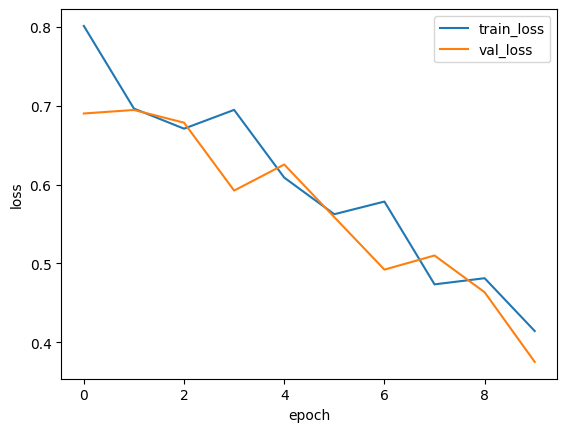

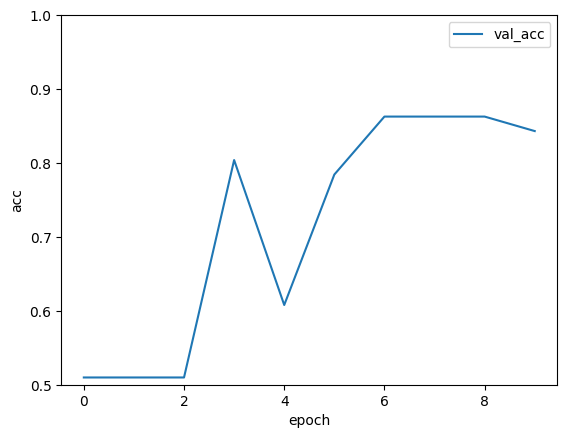

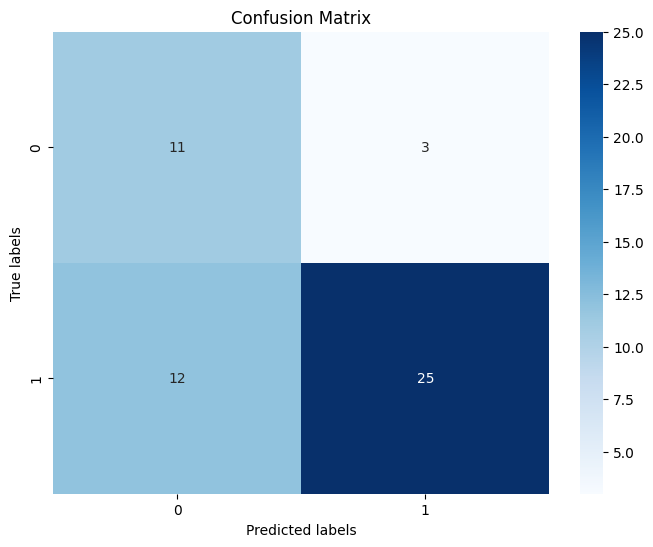

In [83]:
best_params_CNN7={"fc1_out":1242,
                  "learning_rate":0.0012868053981992071,
                  "batch_size":4}
exe_best_model(best_params_CNN7,CNN_7,pretrained=False)

# Resnet

## Find best hyper parameters by optuna

In [90]:
exe_optuna(hypara,"resnet34",pretrained=True)

[I 2024-04-15 05:52:42,647] A new study created in memory with name: no-name-d937b7d3-d225-43f8-9d3c-4252de5372ac


train loss : 0.6902  val_loss : 0.6273  val_acc : 0.6863 
train loss : 0.6129  val_loss : 3.4637  val_acc : 0.5098 
train loss : 0.5662  val_loss : 1.5718  val_acc : 0.6863 
train loss : 0.5407  val_loss : 1.2672  val_acc : 0.6275 
train loss : 0.5655  val_loss : 0.7321  val_acc : 0.5098 
train loss : 0.5750  val_loss : 1.3332  val_acc : 0.5098 
train loss : 0.5706  val_loss : 0.5319  val_acc : 0.7451 
train loss : 0.5372  val_loss : 0.6044  val_acc : 0.7451 
train loss : 0.5402  val_loss : 0.5844  val_acc : 0.8039 


[I 2024-04-15 05:52:58,006] Trial 0 finished with value: 0.49990701130949533 and parameters: {'learning_rate': 0.005271346386354395, 'batch_size': 4}. Best is trial 0 with value: 0.49990701130949533.


train loss : 0.4676  val_loss : 0.4999  val_acc : 0.8627 
train loss : 0.5518  val_loss : 0.4278  val_acc : 0.8235 
train loss : 0.3029  val_loss : 1.1429  val_acc : 0.8235 
train loss : 0.1826  val_loss : 0.3174  val_acc : 0.9216 
train loss : 0.1133  val_loss : 0.5581  val_acc : 0.8235 
train loss : 0.1557  val_loss : 0.7567  val_acc : 0.8431 
train loss : 0.1461  val_loss : 0.4681  val_acc : 0.9608 
train loss : 0.0965  val_loss : 0.9852  val_acc : 0.8235 
train loss : 0.1797  val_loss : 0.2228  val_acc : 0.9608 
train loss : 0.0983  val_loss : 0.3858  val_acc : 0.9412 


[I 2024-04-15 05:53:07,614] Trial 1 finished with value: 0.3659779313020408 and parameters: {'learning_rate': 0.0024944037915547905, 'batch_size': 16}. Best is trial 1 with value: 0.3659779313020408.


train loss : 0.0464  val_loss : 0.3660  val_acc : 0.9608 
train loss : 0.6131  val_loss : 2.0294  val_acc : 0.4902 
train loss : 0.7021  val_loss : 0.6962  val_acc : 0.6863 
train loss : 0.6650  val_loss : 0.8520  val_acc : 0.6863 
train loss : 0.5767  val_loss : 1.0784  val_acc : 0.6863 
train loss : 0.5929  val_loss : 0.6648  val_acc : 0.5882 
train loss : 0.6225  val_loss : 0.5475  val_acc : 0.7255 
train loss : 0.5798  val_loss : 1.3073  val_acc : 0.6275 
train loss : 0.5265  val_loss : 1.2080  val_acc : 0.5098 
train loss : 0.5205  val_loss : 0.6870  val_acc : 0.6471 


[I 2024-04-15 05:53:19,383] Trial 2 finished with value: 0.62002090045384 and parameters: {'learning_rate': 0.009343741252881375, 'batch_size': 8}. Best is trial 1 with value: 0.3659779313020408.


train loss : 0.5553  val_loss : 0.6200  val_acc : 0.7059 
train loss : 0.6364  val_loss : 0.4432  val_acc : 0.8039 
train loss : 0.6630  val_loss : 0.6121  val_acc : 0.5686 
train loss : 0.5671  val_loss : 0.5437  val_acc : 0.8235 
train loss : 0.5543  val_loss : 0.5338  val_acc : 0.7647 
train loss : 0.5080  val_loss : 0.7385  val_acc : 0.5686 
train loss : 0.5904  val_loss : 0.7195  val_acc : 0.5882 
train loss : 0.5655  val_loss : 0.7285  val_acc : 0.7843 
train loss : 0.5777  val_loss : 0.5532  val_acc : 0.7059 
train loss : 0.4922  val_loss : 0.5091  val_acc : 0.8235 


[I 2024-04-15 05:53:34,740] Trial 3 finished with value: 0.6229075631843164 and parameters: {'learning_rate': 0.003981699035690404, 'batch_size': 4}. Best is trial 1 with value: 0.3659779313020408.


train loss : 0.4530  val_loss : 0.6229  val_acc : 0.7647 
train loss : 0.5582  val_loss : 0.6345  val_acc : 0.8039 
train loss : 0.2988  val_loss : 0.4613  val_acc : 0.9216 
train loss : 0.1649  val_loss : 0.9462  val_acc : 0.8235 
train loss : 0.1327  val_loss : 0.4662  val_acc : 0.8431 
train loss : 0.1290  val_loss : 0.7702  val_acc : 0.9020 
train loss : 0.0713  val_loss : 0.4940  val_acc : 0.9020 
train loss : 0.1307  val_loss : 0.7541  val_acc : 0.8235 
train loss : 0.1527  val_loss : 0.5109  val_acc : 0.8039 
train loss : 0.1501  val_loss : 0.7049  val_acc : 0.7647 


[I 2024-04-15 05:53:44,393] Trial 4 finished with value: 0.586945403367281 and parameters: {'learning_rate': 0.0019231909605130122, 'batch_size': 16}. Best is trial 1 with value: 0.3659779313020408.


train loss : 0.1256  val_loss : 0.5869  val_acc : 0.8824 
train loss : 0.6760  val_loss : 5.9773  val_acc : 0.5098 
train loss : 0.6223  val_loss : 1.0369  val_acc : 0.6078 
train loss : 0.6104  val_loss : 0.9418  val_acc : 0.8235 
train loss : 0.6232  val_loss : 7.8980  val_acc : 0.5882 
train loss : 0.5781  val_loss : 0.5199  val_acc : 0.7451 
train loss : 0.5885  val_loss : 3.4513  val_acc : 0.6078 
train loss : 0.5702  val_loss : 4.6111  val_acc : 0.8039 
train loss : 0.6240  val_loss : 1.4298  val_acc : 0.8039 
train loss : 0.5907  val_loss : 7.0400  val_acc : 0.8039 


[I 2024-04-15 05:53:59,720] Trial 5 finished with value: 0.6010228143288538 and parameters: {'learning_rate': 0.009570881492971257, 'batch_size': 4}. Best is trial 1 with value: 0.3659779313020408.


train loss : 0.5891  val_loss : 0.6010  val_acc : 0.7059 
train loss : 0.6056  val_loss : 0.5374  val_acc : 0.7059 
train loss : 0.5856  val_loss : 0.5547  val_acc : 0.5490 
train loss : 0.5355  val_loss : 0.4902  val_acc : 0.8431 
train loss : 0.4126  val_loss : 0.4527  val_acc : 0.7843 
train loss : 0.4000  val_loss : 0.9042  val_acc : 0.6471 
train loss : 0.3578  val_loss : 0.5074  val_acc : 0.8627 
train loss : 0.3362  val_loss : 0.5108  val_acc : 0.8039 
train loss : 0.4356  val_loss : 0.4627  val_acc : 0.8627 
train loss : 0.3236  val_loss : 0.4166  val_acc : 0.8039 


[I 2024-04-15 05:54:15,280] Trial 6 finished with value: 0.48282737456835234 and parameters: {'learning_rate': 0.002495099608565941, 'batch_size': 4}. Best is trial 1 with value: 0.3659779313020408.


train loss : 0.2832  val_loss : 0.4828  val_acc : 0.8431 
train loss : 0.7079  val_loss : 0.6837  val_acc : 0.6667 
train loss : 0.6459  val_loss : 0.6813  val_acc : 0.6078 
train loss : 0.6045  val_loss : 0.6849  val_acc : 0.5490 
train loss : 0.5610  val_loss : 0.6669  val_acc : 0.5686 
train loss : 0.5157  val_loss : 0.6511  val_acc : 0.5882 
train loss : 0.4757  val_loss : 0.6152  val_acc : 0.5686 
train loss : 0.4333  val_loss : 0.5673  val_acc : 0.6863 
train loss : 0.3922  val_loss : 0.5164  val_acc : 0.8627 
train loss : 0.3408  val_loss : 0.4864  val_acc : 0.7843 


[I 2024-04-15 05:54:24,997] Trial 7 finished with value: 0.4452262446284294 and parameters: {'learning_rate': 8.885848878854876e-05, 'batch_size': 16}. Best is trial 1 with value: 0.3659779313020408.


train loss : 0.2984  val_loss : 0.4452  val_acc : 0.8824 
train loss : 0.6048  val_loss : 0.5613  val_acc : 0.6471 
train loss : 0.3924  val_loss : 0.4861  val_acc : 0.8039 
train loss : 0.2732  val_loss : 0.4517  val_acc : 0.8824 
train loss : 0.1820  val_loss : 1.2562  val_acc : 0.7843 
train loss : 0.1134  val_loss : 0.7763  val_acc : 0.8431 
train loss : 0.1140  val_loss : 0.7245  val_acc : 0.8235 
train loss : 0.1613  val_loss : 1.8421  val_acc : 0.7059 
train loss : 0.3459  val_loss : 1.0738  val_acc : 0.8235 
train loss : 0.1950  val_loss : 0.8422  val_acc : 0.6078 


[I 2024-04-15 05:54:34,655] Trial 8 finished with value: 1.0221727155148983 and parameters: {'learning_rate': 0.004453983448827092, 'batch_size': 16}. Best is trial 1 with value: 0.3659779313020408.


train loss : 0.1597  val_loss : 1.0222  val_acc : 0.7843 
train loss : 0.5989  val_loss : 0.7188  val_acc : 0.4902 
train loss : 0.3857  val_loss : 0.6907  val_acc : 0.6078 
train loss : 0.3924  val_loss : 0.9590  val_acc : 0.7451 
train loss : 0.3190  val_loss : 1.2942  val_acc : 0.7059 
train loss : 0.1544  val_loss : 0.7797  val_acc : 0.8627 
train loss : 0.2681  val_loss : 0.3526  val_acc : 0.8627 
train loss : 0.3127  val_loss : 0.6096  val_acc : 0.8431 
train loss : 0.2655  val_loss : 0.5511  val_acc : 0.7647 
train loss : 0.4060  val_loss : 0.6539  val_acc : 0.7255 


[I 2024-04-15 05:54:44,333] Trial 9 finished with value: 1.0794364139437675 and parameters: {'learning_rate': 0.004620033893556676, 'batch_size': 16}. Best is trial 1 with value: 0.3659779313020408.


train loss : 0.2447  val_loss : 1.0794  val_acc : 0.7451 
train loss : 0.5987  val_loss : 0.6837  val_acc : 0.7843 
train loss : 0.4826  val_loss : 2.8990  val_acc : 0.6667 
train loss : 0.5799  val_loss : 0.5507  val_acc : 0.8039 
train loss : 0.5681  val_loss : 0.8743  val_acc : 0.5882 
train loss : 0.4861  val_loss : 0.6272  val_acc : 0.7647 
train loss : 0.5665  val_loss : 0.7233  val_acc : 0.5294 
train loss : 0.5802  val_loss : 0.6086  val_acc : 0.7843 
train loss : 0.6162  val_loss : 0.6805  val_acc : 0.6471 
train loss : 0.5422  val_loss : 0.7997  val_acc : 0.5098 


[I 2024-04-15 05:54:56,124] Trial 10 finished with value: 1.1236100324562617 and parameters: {'learning_rate': 0.006999251790434901, 'batch_size': 8}. Best is trial 1 with value: 0.3659779313020408.


train loss : 0.5727  val_loss : 1.1236  val_acc : 0.6078 
train loss : 0.7263  val_loss : 0.6949  val_acc : 0.4706 
train loss : 0.7068  val_loss : 0.6953  val_acc : 0.4902 
train loss : 0.6933  val_loss : 0.6967  val_acc : 0.4510 
train loss : 0.6818  val_loss : 0.6908  val_acc : 0.5098 
train loss : 0.6717  val_loss : 0.6851  val_acc : 0.5294 
train loss : 0.6608  val_loss : 0.6773  val_acc : 0.6667 
train loss : 0.6488  val_loss : 0.6710  val_acc : 0.6275 
train loss : 0.6433  val_loss : 0.6697  val_acc : 0.7255 
train loss : 0.6360  val_loss : 0.6629  val_acc : 0.6863 


[I 2024-04-15 05:55:05,770] Trial 11 finished with value: 0.6604787260293961 and parameters: {'learning_rate': 1.5755442153371724e-05, 'batch_size': 16}. Best is trial 1 with value: 0.3659779313020408.


train loss : 0.6215  val_loss : 0.6605  val_acc : 0.7255 
train loss : 0.6742  val_loss : 0.6685  val_acc : 0.5490 
train loss : 0.5712  val_loss : 0.6361  val_acc : 0.5490 
train loss : 0.4351  val_loss : 0.5746  val_acc : 0.7255 
train loss : 0.3083  val_loss : 0.4629  val_acc : 0.9412 
train loss : 0.1727  val_loss : 0.3046  val_acc : 0.9216 
train loss : 0.1107  val_loss : 0.2250  val_acc : 0.9216 
train loss : 0.0606  val_loss : 0.1828  val_acc : 0.9020 
train loss : 0.0656  val_loss : 0.1534  val_acc : 0.9412 
train loss : 0.0522  val_loss : 0.1440  val_acc : 0.9412 


[I 2024-04-15 05:55:15,433] Trial 12 finished with value: 0.2521718665957451 and parameters: {'learning_rate': 0.0002914218852884346, 'batch_size': 16}. Best is trial 12 with value: 0.2521718665957451.


train loss : 0.0733  val_loss : 0.2522  val_acc : 0.8824 
train loss : 0.5740  val_loss : 0.5755  val_acc : 0.7843 
train loss : 0.2773  val_loss : 1.5397  val_acc : 0.7451 
train loss : 0.1762  val_loss : 0.4676  val_acc : 0.9020 
train loss : 0.0727  val_loss : 0.4090  val_acc : 0.8824 
train loss : 0.0355  val_loss : 0.3806  val_acc : 0.9020 
train loss : 0.0956  val_loss : 0.8235  val_acc : 0.8824 
train loss : 0.1506  val_loss : 0.4550  val_acc : 0.8824 
train loss : 0.0899  val_loss : 0.3165  val_acc : 0.9020 
train loss : 0.0776  val_loss : 0.3766  val_acc : 0.9020 


[I 2024-04-15 05:55:25,089] Trial 13 finished with value: 0.6751685962080956 and parameters: {'learning_rate': 0.001840669180750619, 'batch_size': 16}. Best is trial 12 with value: 0.2521718665957451.


train loss : 0.0589  val_loss : 0.6752  val_acc : 0.8824 
train loss : 0.6002  val_loss : 0.6032  val_acc : 0.7647 
train loss : 0.3122  val_loss : 0.4774  val_acc : 0.8627 
train loss : 0.1088  val_loss : 0.4496  val_acc : 0.8824 
train loss : 0.0236  val_loss : 0.3907  val_acc : 0.9020 
train loss : 0.0074  val_loss : 0.3772  val_acc : 0.9216 
train loss : 0.0117  val_loss : 0.2804  val_acc : 0.9412 
train loss : 0.0092  val_loss : 1.1924  val_acc : 0.8039 
train loss : 0.1546  val_loss : 0.2928  val_acc : 0.9020 
train loss : 0.2067  val_loss : 0.5582  val_acc : 0.8235 


[I 2024-04-15 05:55:34,764] Trial 14 finished with value: 0.4415318965911865 and parameters: {'learning_rate': 0.0012599671041105035, 'batch_size': 16}. Best is trial 12 with value: 0.2521718665957451.


train loss : 0.1127  val_loss : 0.4415  val_acc : 0.8235 
train loss : 0.5589  val_loss : 0.5844  val_acc : 0.7059 
train loss : 0.2727  val_loss : 0.5701  val_acc : 0.8824 
train loss : 0.1665  val_loss : 1.0097  val_acc : 0.8824 
train loss : 0.0800  val_loss : 1.2256  val_acc : 0.9216 
train loss : 0.0431  val_loss : 1.4053  val_acc : 0.8039 
train loss : 0.1231  val_loss : 1.2140  val_acc : 0.8039 
train loss : 0.0670  val_loss : 1.5725  val_acc : 0.8235 
train loss : 0.1133  val_loss : 0.5305  val_acc : 0.8235 
train loss : 0.2995  val_loss : 0.6241  val_acc : 0.7843 


[I 2024-04-15 05:55:44,505] Trial 15 finished with value: 0.33272283524274826 and parameters: {'learning_rate': 0.0029128125914167835, 'batch_size': 16}. Best is trial 12 with value: 0.2521718665957451.


train loss : 0.2248  val_loss : 0.3327  val_acc : 0.8431 
train loss : 0.5817  val_loss : 0.8259  val_acc : 0.5098 
train loss : 0.4407  val_loss : 0.5831  val_acc : 0.8431 
train loss : 0.3968  val_loss : 0.7166  val_acc : 0.8039 
train loss : 0.3602  val_loss : 0.4340  val_acc : 0.8431 
train loss : 0.1682  val_loss : 0.5910  val_acc : 0.7059 
train loss : 0.2286  val_loss : 1.0378  val_acc : 0.8235 
train loss : 0.3085  val_loss : 0.4920  val_acc : 0.7647 
train loss : 0.2442  val_loss : 0.6928  val_acc : 0.8039 
train loss : 0.2484  val_loss : 1.0098  val_acc : 0.6471 


[I 2024-04-15 05:55:56,258] Trial 16 finished with value: 0.33972855870212826 and parameters: {'learning_rate': 0.003362653397645272, 'batch_size': 8}. Best is trial 12 with value: 0.2521718665957451.


train loss : 0.2115  val_loss : 0.3397  val_acc : 0.9216 
train loss : 0.6166  val_loss : 0.6600  val_acc : 0.5294 
train loss : 0.3790  val_loss : 0.4388  val_acc : 0.9020 
train loss : 0.1637  val_loss : 0.4911  val_acc : 0.8235 
train loss : 0.0782  val_loss : 0.5455  val_acc : 0.7843 
train loss : 0.0375  val_loss : 0.2792  val_acc : 0.9020 
train loss : 0.0497  val_loss : 0.6288  val_acc : 0.8431 
train loss : 0.0519  val_loss : 0.3485  val_acc : 0.8627 
train loss : 0.1222  val_loss : 0.3659  val_acc : 0.8824 
train loss : 0.0722  val_loss : 0.3396  val_acc : 0.8431 


[I 2024-04-15 05:56:05,873] Trial 17 finished with value: 0.3296052049845457 and parameters: {'learning_rate': 0.0008263859566784405, 'batch_size': 16}. Best is trial 12 with value: 0.2521718665957451.


train loss : 0.0706  val_loss : 0.3296  val_acc : 0.9020 
train loss : 0.6177  val_loss : 0.6222  val_acc : 0.5686 
train loss : 0.3601  val_loss : 0.4294  val_acc : 0.9216 
train loss : 0.1566  val_loss : 0.2912  val_acc : 0.9216 
train loss : 0.0440  val_loss : 0.3287  val_acc : 0.8627 
train loss : 0.0107  val_loss : 0.1800  val_acc : 0.9412 
train loss : 0.0371  val_loss : 0.2429  val_acc : 0.9216 
train loss : 0.0253  val_loss : 0.4646  val_acc : 0.9020 
train loss : 0.1141  val_loss : 0.5330  val_acc : 0.8824 
train loss : 0.0727  val_loss : 0.7711  val_acc : 0.7255 


[I 2024-04-15 05:56:15,530] Trial 18 finished with value: 1.0130689041689038 and parameters: {'learning_rate': 0.0009392181090046174, 'batch_size': 16}. Best is trial 12 with value: 0.2521718665957451.


train loss : 0.1297  val_loss : 1.0131  val_acc : 0.8431 
train loss : 0.6159  val_loss : 0.4956  val_acc : 0.7843 
train loss : 0.5613  val_loss : 0.8293  val_acc : 0.6667 
train loss : 0.4655  val_loss : 1.6984  val_acc : 0.5490 
train loss : 0.4064  val_loss : 5.3193  val_acc : 0.6078 
train loss : 0.3569  val_loss : 0.6466  val_acc : 0.7451 
train loss : 0.5498  val_loss : 0.5006  val_acc : 0.8235 
train loss : 0.4126  val_loss : 1.4222  val_acc : 0.8235 
train loss : 0.4568  val_loss : 1.3967  val_acc : 0.6471 
train loss : 0.4951  val_loss : 1.1038  val_acc : 0.6275 


[I 2024-04-15 05:56:27,548] Trial 19 finished with value: 0.543668480856078 and parameters: {'learning_rate': 0.005878575889330455, 'batch_size': 8}. Best is trial 12 with value: 0.2521718665957451.


train loss : 0.3780  val_loss : 0.5437  val_acc : 0.8627 
train loss : 0.6442  val_loss : 0.6615  val_acc : 0.5882 
train loss : 0.5117  val_loss : 1.4367  val_acc : 0.7255 
train loss : 0.5182  val_loss : 0.6135  val_acc : 0.7451 
train loss : 0.3628  val_loss : 0.8839  val_acc : 0.8235 
train loss : 0.2347  val_loss : 0.5105  val_acc : 0.7647 
train loss : 0.2971  val_loss : 1.5258  val_acc : 0.7451 
train loss : 0.1940  val_loss : 1.8295  val_acc : 0.6275 
train loss : 0.3533  val_loss : 3.0188  val_acc : 0.6471 
train loss : 0.3123  val_loss : 0.5811  val_acc : 0.8235 


[I 2024-04-15 05:56:37,165] Trial 20 finished with value: 0.3805331401526928 and parameters: {'learning_rate': 0.007700561093946336, 'batch_size': 16}. Best is trial 12 with value: 0.2521718665957451.


train loss : 0.2153  val_loss : 0.3805  val_acc : 0.8824 
train loss : 0.5972  val_loss : 0.6434  val_acc : 0.5686 
train loss : 0.3422  val_loss : 0.4763  val_acc : 0.8824 
train loss : 0.1361  val_loss : 0.3020  val_acc : 0.9412 
train loss : 0.0368  val_loss : 0.4820  val_acc : 0.8431 
train loss : 0.0136  val_loss : 0.5160  val_acc : 0.9020 
train loss : 0.0100  val_loss : 0.4735  val_acc : 0.9216 
train loss : 0.0167  val_loss : 0.3315  val_acc : 0.9020 
train loss : 0.0863  val_loss : 0.2636  val_acc : 0.9608 
train loss : 0.1344  val_loss : 0.3229  val_acc : 0.8431 


[I 2024-04-15 05:56:46,796] Trial 21 finished with value: 0.5959867483470589 and parameters: {'learning_rate': 0.0010021503880205136, 'batch_size': 16}. Best is trial 12 with value: 0.2521718665957451.


train loss : 0.0966  val_loss : 0.5960  val_acc : 0.8235 
train loss : 0.5640  val_loss : 0.5565  val_acc : 0.7255 
train loss : 0.3170  val_loss : 0.6290  val_acc : 0.7843 
train loss : 0.1673  val_loss : 1.5729  val_acc : 0.7059 
train loss : 0.1360  val_loss : 1.0485  val_acc : 0.8431 
train loss : 0.1844  val_loss : 0.6289  val_acc : 0.8431 
train loss : 0.2491  val_loss : 1.7815  val_acc : 0.7255 
train loss : 0.1848  val_loss : 0.7252  val_acc : 0.7843 
train loss : 0.2338  val_loss : 0.4500  val_acc : 0.9216 
train loss : 0.0999  val_loss : 0.4622  val_acc : 0.8824 


[I 2024-04-15 05:56:56,416] Trial 22 finished with value: 0.6466814670711756 and parameters: {'learning_rate': 0.0031490285064755177, 'batch_size': 16}. Best is trial 12 with value: 0.2521718665957451.


train loss : 0.0642  val_loss : 0.6467  val_acc : 0.8627 
train loss : 0.6194  val_loss : 0.6297  val_acc : 0.5490 
train loss : 0.3922  val_loss : 0.4577  val_acc : 0.8824 
train loss : 0.1859  val_loss : 0.5049  val_acc : 0.8431 
train loss : 0.0618  val_loss : 0.5494  val_acc : 0.8431 
train loss : 0.0146  val_loss : 0.3724  val_acc : 0.8824 
train loss : 0.0147  val_loss : 0.1383  val_acc : 0.9608 
train loss : 0.0280  val_loss : 0.8121  val_acc : 0.8235 
train loss : 0.1719  val_loss : 0.3144  val_acc : 0.8824 
train loss : 0.1989  val_loss : 0.2490  val_acc : 0.8824 


[I 2024-04-15 05:57:06,058] Trial 23 finished with value: 0.24139748280867934 and parameters: {'learning_rate': 0.0007878199051375506, 'batch_size': 16}. Best is trial 23 with value: 0.24139748280867934.


train loss : 0.0758  val_loss : 0.2414  val_acc : 0.9412 
train loss : 0.6537  val_loss : 0.6591  val_acc : 0.5490 
train loss : 0.4900  val_loss : 0.5982  val_acc : 0.7059 
train loss : 0.2919  val_loss : 0.4217  val_acc : 0.8431 
train loss : 0.1539  val_loss : 0.2781  val_acc : 0.9412 
train loss : 0.0549  val_loss : 0.2391  val_acc : 0.9216 
train loss : 0.0322  val_loss : 0.2060  val_acc : 0.9412 
train loss : 0.0195  val_loss : 0.1570  val_acc : 0.9412 
train loss : 0.0630  val_loss : 0.1495  val_acc : 0.9216 
train loss : 0.0760  val_loss : 0.3838  val_acc : 0.8039 


[I 2024-04-15 05:57:15,691] Trial 24 finished with value: 0.32839953154325485 and parameters: {'learning_rate': 0.0004706085199194513, 'batch_size': 16}. Best is trial 23 with value: 0.24139748280867934.


train loss : 0.0648  val_loss : 0.3284  val_acc : 0.8627 
train loss : 0.6882  val_loss : 0.6800  val_acc : 0.5490 
train loss : 0.5989  val_loss : 0.6698  val_acc : 0.5098 
train loss : 0.5157  val_loss : 0.6504  val_acc : 0.5294 
train loss : 0.4116  val_loss : 0.5734  val_acc : 0.6667 
train loss : 0.3028  val_loss : 0.5097  val_acc : 0.8431 
train loss : 0.2279  val_loss : 0.4580  val_acc : 0.7255 
train loss : 0.1549  val_loss : 0.3456  val_acc : 0.8824 
train loss : 0.1249  val_loss : 0.2631  val_acc : 0.9020 
train loss : 0.0732  val_loss : 0.2209  val_acc : 0.9216 


[I 2024-04-15 05:57:25,310] Trial 25 finished with value: 0.21221944317221642 and parameters: {'learning_rate': 0.00019597225106185055, 'batch_size': 16}. Best is trial 25 with value: 0.21221944317221642.


train loss : 0.0553  val_loss : 0.2122  val_acc : 0.9412 
train loss : 0.5712  val_loss : 0.6029  val_acc : 0.7843 
train loss : 0.2826  val_loss : 0.6860  val_acc : 0.7843 
train loss : 0.1386  val_loss : 0.2991  val_acc : 0.9020 
train loss : 0.0689  val_loss : 0.3201  val_acc : 0.8824 
train loss : 0.0353  val_loss : 0.3400  val_acc : 0.9020 
train loss : 0.0777  val_loss : 0.3621  val_acc : 0.9216 
train loss : 0.0608  val_loss : 0.5486  val_acc : 0.8431 
train loss : 0.1440  val_loss : 0.7896  val_acc : 0.8039 
train loss : 0.2349  val_loss : 0.2258  val_acc : 0.8824 


[I 2024-04-15 05:57:34,943] Trial 26 finished with value: 0.3312098328024149 and parameters: {'learning_rate': 0.001807996132388587, 'batch_size': 16}. Best is trial 25 with value: 0.21221944317221642.


train loss : 0.1057  val_loss : 0.3312  val_acc : 0.9412 
train loss : 0.5905  val_loss : 0.5779  val_acc : 0.8431 
train loss : 0.3292  val_loss : 0.2992  val_acc : 0.9412 
train loss : 0.1943  val_loss : 0.6869  val_acc : 0.8235 
train loss : 0.1664  val_loss : 0.5865  val_acc : 0.8235 
train loss : 0.0920  val_loss : 0.1634  val_acc : 0.9608 
train loss : 0.1378  val_loss : 0.5055  val_acc : 0.8431 
train loss : 0.0796  val_loss : 0.6049  val_acc : 0.8235 
train loss : 0.1070  val_loss : 0.2270  val_acc : 0.9216 
train loss : 0.1953  val_loss : 0.8499  val_acc : 0.7451 


[I 2024-04-15 05:57:44,581] Trial 27 finished with value: 0.49793655052781105 and parameters: {'learning_rate': 0.0018050711551898836, 'batch_size': 16}. Best is trial 25 with value: 0.21221944317221642.


train loss : 0.1505  val_loss : 0.4979  val_acc : 0.8235 
train loss : 0.5649  val_loss : 0.4598  val_acc : 0.7843 
train loss : 0.4778  val_loss : 0.5333  val_acc : 0.8039 
train loss : 0.3180  val_loss : 0.5324  val_acc : 0.8235 
train loss : 0.3357  val_loss : 0.4738  val_acc : 0.8431 
train loss : 0.2381  val_loss : 0.3582  val_acc : 0.8824 
train loss : 0.2870  val_loss : 0.5874  val_acc : 0.7843 
train loss : 0.2683  val_loss : 0.5192  val_acc : 0.8627 
train loss : 0.2248  val_loss : 0.4247  val_acc : 0.8824 
train loss : 0.1823  val_loss : 0.4382  val_acc : 0.7843 


[I 2024-04-15 05:58:00,059] Trial 28 finished with value: 0.23743847041175917 and parameters: {'learning_rate': 0.001368171214495322, 'batch_size': 4}. Best is trial 25 with value: 0.21221944317221642.


train loss : 0.3083  val_loss : 0.2374  val_acc : 0.9412 
train loss : 0.6598  val_loss : 0.7324  val_acc : 0.5882 
train loss : 0.6650  val_loss : 0.7116  val_acc : 0.6863 
train loss : 0.5643  val_loss : 0.8212  val_acc : 0.7451 
train loss : 0.5733  val_loss : 0.6612  val_acc : 0.7451 
train loss : 0.5903  val_loss : 0.5909  val_acc : 0.7059 
train loss : 0.5593  val_loss : 1.2705  val_acc : 0.3725 
train loss : 0.5747  val_loss : 0.6043  val_acc : 0.6667 
train loss : 0.6000  val_loss : 0.5921  val_acc : 0.6863 
train loss : 0.5408  val_loss : 0.6481  val_acc : 0.6471 


[I 2024-04-15 05:58:15,330] Trial 29 finished with value: 0.5140209702345041 and parameters: {'learning_rate': 0.005762332265035498, 'batch_size': 4}. Best is trial 25 with value: 0.21221944317221642.


train loss : 0.5366  val_loss : 0.5140  val_acc : 0.8039 
Best Hyperparameters: {'learning_rate': 0.00019597225106185055, 'batch_size': 16}


{'learning_rate': 0.00019597225106185055, 'batch_size': 16}

## Best model of resnet34

learning rate : 0.00019597225106185055  batch size : 16
train loss : 0.6882  val_loss : 0.6800  val_acc : 0.5490 
train loss : 0.5989  val_loss : 0.6698  val_acc : 0.5098 
train loss : 0.5157  val_loss : 0.6504  val_acc : 0.5294 
train loss : 0.4116  val_loss : 0.5734  val_acc : 0.6667 
train loss : 0.3028  val_loss : 0.5097  val_acc : 0.8431 
train loss : 0.2279  val_loss : 0.4580  val_acc : 0.7255 
train loss : 0.1549  val_loss : 0.3456  val_acc : 0.8824 
train loss : 0.1249  val_loss : 0.2631  val_acc : 0.9020 
train loss : 0.0732  val_loss : 0.2209  val_acc : 0.9216 
train loss : 0.0553  val_loss : 0.2122  val_acc : 0.9412 
test accuracy : 0.9607843137254902


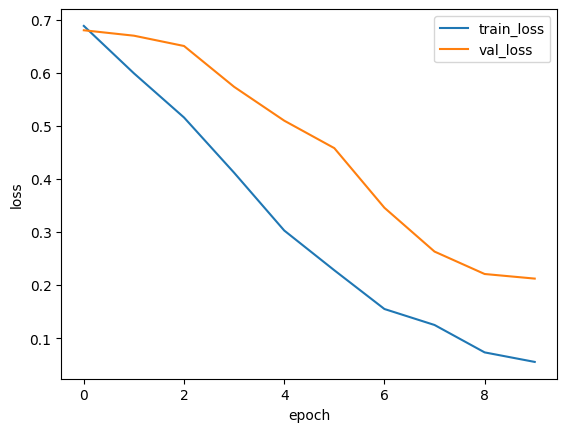

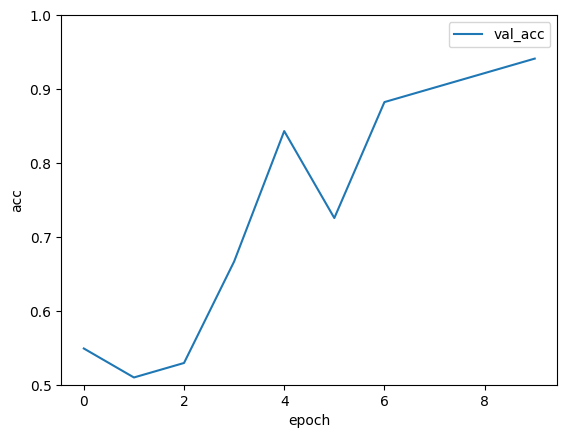

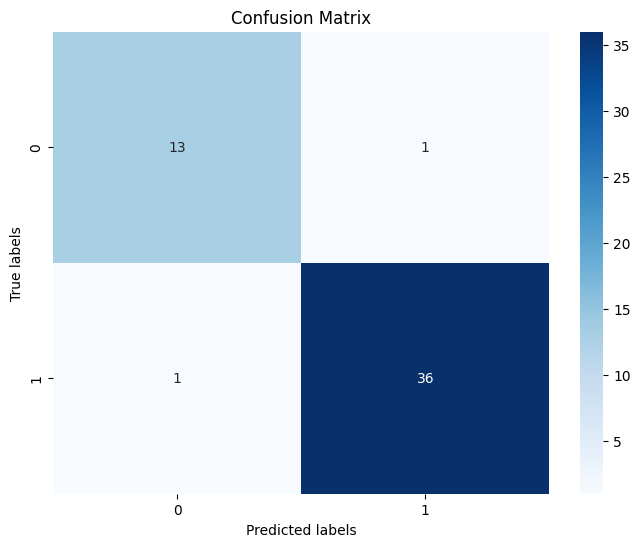

In [93]:
best_hypara={
            "learning_rate":0.00019597225106185055,
            "batch_size":16}
exe_best_model(best_hypara,"resnet34",pretrained=True)

# EfficientnetV2 b0

## Find best hyper parameters by optuna

In [95]:
exe_optuna(config.hypara,"efficientnet_b0",pretrained=True)

[I 2024-04-15 06:12:03,994] A new study created in memory with name: no-name-b767d00e-b310-4c83-bf41-269534b2974d


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

train loss : 5.6707  val_loss : 0.9705  val_acc : 0.6863 
train loss : 1.2112  val_loss : 3.2846  val_acc : 0.5294 
train loss : 0.9074  val_loss : 0.5922  val_acc : 0.7059 
train loss : 0.7270  val_loss : 1.9855  val_acc : 0.6275 
train loss : 0.6537  val_loss : 0.4416  val_acc : 0.8039 
train loss : 0.4633  val_loss : 0.3768  val_acc : 0.8431 
train loss : 0.4187  val_loss : 0.8251  val_acc : 0.8039 
train loss : 0.5491  val_loss : 0.3394  val_acc : 0.8627 
train loss : 0.3620  val_loss : 0.6799  val_acc : 0.7059 


[I 2024-04-15 06:12:22,155] Trial 0 finished with value: 0.4812567246934542 and parameters: {'learning_rate': 0.0022321534971950505, 'batch_size': 4}. Best is trial 0 with value: 0.4812567246934542.


train loss : 0.6052  val_loss : 0.4813  val_acc : 0.8235 
train loss : 9.3429  val_loss : 2.7131  val_acc : 0.4902 
train loss : 0.8115  val_loss : 0.9918  val_acc : 0.8235 
train loss : 0.8316  val_loss : 1.7032  val_acc : 0.6667 
train loss : 0.8388  val_loss : 0.8855  val_acc : 0.6471 
train loss : 0.7254  val_loss : 0.5824  val_acc : 0.7647 
train loss : 0.5355  val_loss : 0.5908  val_acc : 0.7255 
train loss : 0.5818  val_loss : 0.7135  val_acc : 0.8235 
train loss : 1.2867  val_loss : 4.1545  val_acc : 0.8039 
train loss : 0.9893  val_loss : 2.0965  val_acc : 0.7059 


[I 2024-04-15 06:12:39,649] Trial 1 finished with value: 2.471979694870802 and parameters: {'learning_rate': 0.007024046755840078, 'batch_size': 4}. Best is trial 0 with value: 0.4812567246934542.


train loss : 1.1024  val_loss : 2.4720  val_acc : 0.6667 
train loss : 7.8190  val_loss : 140.4236  val_acc : 0.8431 
train loss : 3.0666  val_loss : 19.2073  val_acc : 0.4118 
train loss : 0.4855  val_loss : 1.7873  val_acc : 0.7647 
train loss : 0.3854  val_loss : 1.7493  val_acc : 0.7647 
train loss : 0.2882  val_loss : 0.5272  val_acc : 0.7843 
train loss : 0.3057  val_loss : 0.9209  val_acc : 0.7843 
train loss : 0.4853  val_loss : 1.4863  val_acc : 0.7843 
train loss : 0.4070  val_loss : 1.8173  val_acc : 0.5686 
train loss : 0.2948  val_loss : 0.5548  val_acc : 0.8235 


[I 2024-04-15 06:12:51,045] Trial 2 finished with value: 0.6801080490861621 and parameters: {'learning_rate': 0.0036395113786660055, 'batch_size': 8}. Best is trial 0 with value: 0.4812567246934542.


train loss : 0.3211  val_loss : 0.6801  val_acc : 0.7255 
train loss : 6.8491  val_loss : 13.2521  val_acc : 0.6667 
train loss : 4.1094  val_loss : 13.1806  val_acc : 0.6078 
train loss : 1.9699  val_loss : 4.1787  val_acc : 0.6275 
train loss : 1.0217  val_loss : 6.0744  val_acc : 0.7255 
train loss : 0.8009  val_loss : 1.1805  val_acc : 0.7843 
train loss : 0.5091  val_loss : 1.2066  val_acc : 0.8627 
train loss : 0.3758  val_loss : 1.2953  val_acc : 0.8039 
train loss : 0.4022  val_loss : 0.7189  val_acc : 0.9412 
train loss : 0.3210  val_loss : 0.6691  val_acc : 0.8235 


[I 2024-04-15 06:13:00,148] Trial 3 finished with value: 0.5746258459985256 and parameters: {'learning_rate': 0.00337994809603703, 'batch_size': 16}. Best is trial 0 with value: 0.4812567246934542.


train loss : 0.2902  val_loss : 0.5746  val_acc : 0.9020 
train loss : 9.4543  val_loss : 11.3390  val_acc : 0.4510 
train loss : 1.1087  val_loss : 0.9090  val_acc : 0.5882 
train loss : 1.1559  val_loss : 0.7399  val_acc : 0.6863 
train loss : 0.9434  val_loss : 0.7707  val_acc : 0.7059 
train loss : 0.7190  val_loss : 0.7212  val_acc : 0.7647 
train loss : 0.7374  val_loss : 0.6275  val_acc : 0.6667 
train loss : 0.5771  val_loss : 0.6524  val_acc : 0.7843 
train loss : 0.9275  val_loss : 0.6453  val_acc : 0.7255 
train loss : 0.5159  val_loss : 0.6527  val_acc : 0.7647 


[I 2024-04-15 06:13:17,745] Trial 4 finished with value: 0.5212393254041672 and parameters: {'learning_rate': 0.009655322833821707, 'batch_size': 4}. Best is trial 0 with value: 0.4812567246934542.


train loss : 0.5261  val_loss : 0.5212  val_acc : 0.7647 
train loss : 1.6978  val_loss : 2.1290  val_acc : 0.7647 
train loss : 0.6551  val_loss : 2.2160  val_acc : 0.9020 
train loss : 0.2909  val_loss : 1.8243  val_acc : 0.9020 
train loss : 0.0425  val_loss : 1.0687  val_acc : 0.8431 
train loss : 0.0587  val_loss : 1.1611  val_acc : 0.8431 
train loss : 0.1369  val_loss : 2.4657  val_acc : 0.8627 
train loss : 0.0406  val_loss : 1.4534  val_acc : 0.8235 
train loss : 0.7167  val_loss : 1.4645  val_acc : 0.9020 
train loss : 0.0945  val_loss : 2.6581  val_acc : 0.9020 


[I 2024-04-15 06:13:26,755] Trial 5 finished with value: 2.8367269188165665 and parameters: {'learning_rate': 0.00037097840261266635, 'batch_size': 16}. Best is trial 0 with value: 0.4812567246934542.


train loss : 0.0929  val_loss : 2.8367  val_acc : 0.8824 
train loss : 11.2717  val_loss : 552.3372  val_acc : 0.5098 
train loss : 1.4949  val_loss : 70.9421  val_acc : 0.5098 
train loss : 1.2364  val_loss : 0.5895  val_acc : 0.7451 
train loss : 1.2062  val_loss : 4.9694  val_acc : 0.5098 
train loss : 0.7174  val_loss : 0.6225  val_acc : 0.6471 
train loss : 0.8649  val_loss : 0.5837  val_acc : 0.7059 
train loss : 0.6493  val_loss : 14.5319  val_acc : 0.6863 
train loss : 1.1331  val_loss : 4.6167  val_acc : 0.5098 
train loss : 1.0058  val_loss : 0.8037  val_acc : 0.7647 


[I 2024-04-15 06:13:38,054] Trial 6 finished with value: 5.575589486530849 and parameters: {'learning_rate': 0.0068716808656368415, 'batch_size': 8}. Best is trial 0 with value: 0.4812567246934542.


train loss : 1.0971  val_loss : 5.5756  val_acc : 0.3529 
train loss : 8.0084  val_loss : 28.2678  val_acc : 0.2549 
train loss : 1.2385  val_loss : 1.1776  val_acc : 0.5686 
train loss : 1.4468  val_loss : 1.2359  val_acc : 0.5294 
train loss : 0.7930  val_loss : 1.2734  val_acc : 0.4706 
train loss : 0.6309  val_loss : 1.0375  val_acc : 0.5686 
train loss : 0.7024  val_loss : 1.3722  val_acc : 0.6078 
train loss : 0.8163  val_loss : 0.7961  val_acc : 0.6275 
train loss : 0.6497  val_loss : 0.5876  val_acc : 0.6863 
train loss : 0.5017  val_loss : 1.1684  val_acc : 0.5098 


[I 2024-04-15 06:13:55,474] Trial 7 finished with value: 0.75213223695755 and parameters: {'learning_rate': 0.008514269500318259, 'batch_size': 4}. Best is trial 0 with value: 0.4812567246934542.


train loss : 0.5897  val_loss : 0.7521  val_acc : 0.6863 
train loss : 9.6935  val_loss : 37.9317  val_acc : 0.7059 
train loss : 1.1739  val_loss : 69.8639  val_acc : 0.6667 
train loss : 1.1003  val_loss : 0.9452  val_acc : 0.5294 
train loss : 0.7701  val_loss : 6.8057  val_acc : 0.7647 
train loss : 0.4731  val_loss : 0.8238  val_acc : 0.5882 
train loss : 0.6261  val_loss : 12.6972  val_acc : 0.6078 
train loss : 0.8202  val_loss : 1.0275  val_acc : 0.6275 
train loss : 0.7234  val_loss : 0.6437  val_acc : 0.8235 
train loss : 0.8687  val_loss : 0.6106  val_acc : 0.8235 


[I 2024-04-15 06:14:06,717] Trial 8 finished with value: 0.673661972795214 and parameters: {'learning_rate': 0.003687205017648902, 'batch_size': 8}. Best is trial 0 with value: 0.4812567246934542.


train loss : 0.7361  val_loss : 0.6737  val_acc : 0.8235 
train loss : 6.3054  val_loss : 3.6876  val_acc : 0.4314 
train loss : 0.8630  val_loss : 1.8713  val_acc : 0.4902 
train loss : 0.5831  val_loss : 0.6501  val_acc : 0.7451 
train loss : 0.6314  val_loss : 0.6582  val_acc : 0.8039 
train loss : 0.5039  val_loss : 0.4636  val_acc : 0.7255 
train loss : 0.3824  val_loss : 0.4302  val_acc : 0.8431 
train loss : 0.4344  val_loss : 0.8971  val_acc : 0.7647 
train loss : 0.5051  val_loss : 0.5421  val_acc : 0.8039 
train loss : 0.2617  val_loss : 0.6951  val_acc : 0.8431 


[I 2024-04-15 06:14:24,339] Trial 9 finished with value: 0.6175381979690149 and parameters: {'learning_rate': 0.0033036696167831454, 'batch_size': 4}. Best is trial 0 with value: 0.4812567246934542.


train loss : 0.6677  val_loss : 0.6175  val_acc : 0.7647 
train loss : 2.9275  val_loss : 3.3202  val_acc : 0.7647 
train loss : 2.1417  val_loss : 0.9174  val_acc : 0.8235 
train loss : 1.2386  val_loss : 1.4508  val_acc : 0.8235 
train loss : 0.7436  val_loss : 0.7170  val_acc : 0.8627 
train loss : 0.1620  val_loss : 0.4811  val_acc : 0.8627 
train loss : 0.3175  val_loss : 1.0828  val_acc : 0.8235 
train loss : 0.7020  val_loss : 1.3515  val_acc : 0.9020 
train loss : 1.1798  val_loss : 1.6938  val_acc : 0.6275 
train loss : 0.5930  val_loss : 0.8555  val_acc : 0.8235 


[I 2024-04-15 06:14:41,786] Trial 10 finished with value: 0.800851663695889 and parameters: {'learning_rate': 0.0005697290032455208, 'batch_size': 4}. Best is trial 0 with value: 0.4812567246934542.


train loss : 0.4754  val_loss : 0.8009  val_acc : 0.8039 
train loss : 6.1457  val_loss : 2.6442  val_acc : 0.5686 
train loss : 1.1576  val_loss : 6.1969  val_acc : 0.4706 
train loss : 1.0059  val_loss : 13.9724  val_acc : 0.5098 
train loss : 0.8544  val_loss : 1.3488  val_acc : 0.4706 
train loss : 0.7955  val_loss : 1.5744  val_acc : 0.5294 
train loss : 0.6910  val_loss : 0.8731  val_acc : 0.5294 
train loss : 0.8658  val_loss : 2.9351  val_acc : 0.4902 
train loss : 0.7315  val_loss : 4.0912  val_acc : 0.6863 
train loss : 0.6074  val_loss : 1.3036  val_acc : 0.5098 


[I 2024-04-15 06:14:59,267] Trial 11 finished with value: 1.0519890737934754 and parameters: {'learning_rate': 0.005796342212078517, 'batch_size': 4}. Best is trial 0 with value: 0.4812567246934542.


train loss : 0.7218  val_loss : 1.0520  val_acc : 0.6667 
train loss : 10.2797  val_loss : 26.8457  val_acc : 0.4314 
train loss : 1.2503  val_loss : 1.2653  val_acc : 0.7059 
train loss : 1.3629  val_loss : 1.3347  val_acc : 0.5686 
train loss : 0.8375  val_loss : 1.5107  val_acc : 0.6667 
train loss : 0.6448  val_loss : 2.0258  val_acc : 0.5882 
train loss : 0.7761  val_loss : 0.9637  val_acc : 0.6471 
train loss : 0.9395  val_loss : 2.6437  val_acc : 0.6078 
train loss : 0.9518  val_loss : 0.8034  val_acc : 0.6275 
train loss : 0.8444  val_loss : 12.3835  val_acc : 0.5686 


[I 2024-04-15 06:15:16,759] Trial 12 finished with value: 0.9918239546509889 and parameters: {'learning_rate': 0.009982359187609502, 'batch_size': 4}. Best is trial 0 with value: 0.4812567246934542.


train loss : 0.8617  val_loss : 0.9918  val_acc : 0.8431 
train loss : 4.7784  val_loss : 1.3095  val_acc : 0.8039 
train loss : 1.7721  val_loss : 4.6237  val_acc : 0.6471 
train loss : 0.7302  val_loss : 1.9160  val_acc : 0.7843 
train loss : 0.5371  val_loss : 0.8012  val_acc : 0.8431 
train loss : 0.3240  val_loss : 0.4982  val_acc : 0.9216 
train loss : 0.2395  val_loss : 0.4185  val_acc : 0.8039 
train loss : 0.3941  val_loss : 0.6825  val_acc : 0.8431 
train loss : 0.3789  val_loss : 0.5001  val_acc : 0.8627 
train loss : 0.3283  val_loss : 0.5162  val_acc : 0.7843 


[I 2024-04-15 06:15:34,254] Trial 13 finished with value: 0.4424997576727317 and parameters: {'learning_rate': 0.0018596540588586758, 'batch_size': 4}. Best is trial 13 with value: 0.4424997576727317.


train loss : 0.3518  val_loss : 0.4425  val_acc : 0.8824 
train loss : 4.4282  val_loss : 2.3206  val_acc : 0.7451 
train loss : 1.9852  val_loss : 4.4962  val_acc : 0.8235 
train loss : 0.5212  val_loss : 8.0465  val_acc : 0.7647 
train loss : 0.0667  val_loss : 4.6533  val_acc : 0.8627 
train loss : 0.2856  val_loss : 6.0788  val_acc : 0.8235 
train loss : 0.2242  val_loss : 1.3337  val_acc : 0.9020 
train loss : 0.3469  val_loss : 1.7472  val_acc : 0.9020 
train loss : 0.3685  val_loss : 1.7011  val_acc : 0.7451 
train loss : 0.1723  val_loss : 1.0080  val_acc : 0.7255 


[I 2024-04-15 06:15:43,283] Trial 14 finished with value: 1.413252379745245 and parameters: {'learning_rate': 0.0017049835344516045, 'batch_size': 16}. Best is trial 13 with value: 0.4424997576727317.


train loss : 0.1910  val_loss : 1.4133  val_acc : 0.7843 
train loss : 6.3853  val_loss : 9.3381  val_acc : 0.7059 
train loss : 1.9961  val_loss : 1.4178  val_acc : 0.6471 
train loss : 0.7818  val_loss : 1.7956  val_acc : 0.5294 
train loss : 0.9642  val_loss : 1.9511  val_acc : 0.7059 
train loss : 0.7668  val_loss : 10.7584  val_acc : 0.5098 
train loss : 0.6251  val_loss : 0.5972  val_acc : 0.7059 
train loss : 0.5503  val_loss : 2.4819  val_acc : 0.6863 
train loss : 0.5610  val_loss : 0.5966  val_acc : 0.7647 
train loss : 0.4537  val_loss : 7.6368  val_acc : 0.7647 


[I 2024-04-15 06:16:00,829] Trial 15 finished with value: 1.44886454853874 and parameters: {'learning_rate': 0.0022512624563565628, 'batch_size': 4}. Best is trial 13 with value: 0.4424997576727317.


train loss : 0.5663  val_loss : 1.4489  val_acc : 0.8039 
train loss : 4.9714  val_loss : 5.2265  val_acc : 0.8235 
train loss : 1.2847  val_loss : 0.9997  val_acc : 0.8627 
train loss : 0.7903  val_loss : 1.3674  val_acc : 0.8039 
train loss : 0.6221  val_loss : 0.6573  val_acc : 0.8039 
train loss : 0.4063  val_loss : 0.7294  val_acc : 0.8235 
train loss : 0.4487  val_loss : 0.3462  val_acc : 0.8824 
train loss : 0.3627  val_loss : 0.4749  val_acc : 0.8824 
train loss : 0.3417  val_loss : 0.4150  val_acc : 0.8431 
train loss : 0.1977  val_loss : 0.6780  val_acc : 0.9216 


[I 2024-04-15 06:16:18,312] Trial 16 finished with value: 0.2907188359889775 and parameters: {'learning_rate': 0.0018406427797968729, 'batch_size': 4}. Best is trial 16 with value: 0.2907188359889775.


train loss : 0.1975  val_loss : 0.2907  val_acc : 0.9216 
train loss : 4.5449  val_loss : 3.6685  val_acc : 0.5294 
train loss : 0.8297  val_loss : 0.4953  val_acc : 0.8627 
train loss : 0.7275  val_loss : 0.8581  val_acc : 0.7451 
train loss : 0.6646  val_loss : 0.7173  val_acc : 0.7059 
train loss : 0.5558  val_loss : 0.8283  val_acc : 0.6471 
train loss : 0.6130  val_loss : 0.7447  val_acc : 0.6471 
train loss : 0.7188  val_loss : 0.5012  val_acc : 0.8824 
train loss : 0.5183  val_loss : 0.6069  val_acc : 0.7451 
train loss : 0.4059  val_loss : 0.6812  val_acc : 0.8431 


[I 2024-04-15 06:16:35,870] Trial 17 finished with value: 0.44653375962605846 and parameters: {'learning_rate': 0.004601062492445393, 'batch_size': 4}. Best is trial 16 with value: 0.2907188359889775.


train loss : 0.6533  val_loss : 0.4465  val_acc : 0.9020 
train loss : 3.9425  val_loss : 2.9115  val_acc : 0.7451 
train loss : 1.1452  val_loss : 9.5209  val_acc : 0.6078 
train loss : 0.8037  val_loss : 6.5524  val_acc : 0.8431 
train loss : 0.2382  val_loss : 3.8788  val_acc : 0.8431 
train loss : 0.0482  val_loss : 2.4266  val_acc : 0.8824 
train loss : 0.1067  val_loss : 1.7494  val_acc : 0.8627 
train loss : 0.1332  val_loss : 1.2459  val_acc : 0.9020 
train loss : 0.1937  val_loss : 0.6109  val_acc : 0.9020 
train loss : 0.1976  val_loss : 0.2694  val_acc : 0.9216 


[I 2024-04-15 06:16:44,920] Trial 18 finished with value: 0.3819456435739994 and parameters: {'learning_rate': 0.0013473677950404921, 'batch_size': 16}. Best is trial 16 with value: 0.2907188359889775.


train loss : 0.3189  val_loss : 0.3819  val_acc : 0.9020 
train loss : 1.5210  val_loss : 2.4704  val_acc : 0.7059 
train loss : 0.3177  val_loss : 2.6930  val_acc : 0.7451 
train loss : 0.0134  val_loss : 2.2894  val_acc : 0.7843 
train loss : 0.0064  val_loss : 1.9874  val_acc : 0.7647 
train loss : 0.0086  val_loss : 1.8530  val_acc : 0.8039 
train loss : 0.0282  val_loss : 1.5957  val_acc : 0.8824 
train loss : 0.0018  val_loss : 1.4214  val_acc : 0.9216 
train loss : 0.1574  val_loss : 1.3814  val_acc : 0.8824 
train loss : 0.0368  val_loss : 1.2758  val_acc : 0.8431 


[I 2024-04-15 06:16:54,005] Trial 19 finished with value: 1.4702188033843413 and parameters: {'learning_rate': 0.00011953400309454017, 'batch_size': 16}. Best is trial 16 with value: 0.2907188359889775.


train loss : 0.0768  val_loss : 1.4702  val_acc : 0.8627 
train loss : 4.3464  val_loss : 2.3501  val_acc : 0.6863 
train loss : 1.5229  val_loss : 2.3979  val_acc : 0.6863 
train loss : 0.3293  val_loss : 16.8495  val_acc : 0.8431 
train loss : 0.2314  val_loss : 6.6328  val_acc : 0.8431 
train loss : 0.1158  val_loss : 1.9732  val_acc : 0.8235 
train loss : 0.1888  val_loss : 0.7564  val_acc : 0.8824 
train loss : 0.0246  val_loss : 0.3435  val_acc : 0.9020 
train loss : 0.1390  val_loss : 0.2509  val_acc : 0.9020 
train loss : 0.4717  val_loss : 0.9335  val_acc : 0.8824 


[I 2024-04-15 06:17:03,099] Trial 20 finished with value: 0.6009899787604809 and parameters: {'learning_rate': 0.0013345839864859232, 'batch_size': 16}. Best is trial 16 with value: 0.2907188359889775.


train loss : 0.2676  val_loss : 0.6010  val_acc : 0.8824 
train loss : 4.0384  val_loss : 2.8328  val_acc : 0.6471 
train loss : 1.5355  val_loss : 5.1293  val_acc : 0.7059 
train loss : 0.3377  val_loss : 7.2051  val_acc : 0.7647 
train loss : 0.2867  val_loss : 7.2236  val_acc : 0.8431 
train loss : 0.1498  val_loss : 6.5872  val_acc : 0.9020 
train loss : 0.1706  val_loss : 2.3539  val_acc : 0.7843 
train loss : 0.2400  val_loss : 1.3138  val_acc : 0.8235 
train loss : 0.3776  val_loss : 1.8436  val_acc : 0.8627 
train loss : 0.2033  val_loss : 5.1321  val_acc : 0.8431 


[I 2024-04-15 06:17:12,371] Trial 21 finished with value: 0.6465423165354878 and parameters: {'learning_rate': 0.0024595859766490405, 'batch_size': 16}. Best is trial 16 with value: 0.2907188359889775.


train loss : 0.1932  val_loss : 0.6465  val_acc : 0.9020 
train loss : 3.8043  val_loss : 4.0522  val_acc : 0.5490 
train loss : 1.2673  val_loss : 5.2559  val_acc : 0.6078 
train loss : 0.6078  val_loss : 6.3774  val_acc : 0.8627 
train loss : 0.3980  val_loss : 2.6746  val_acc : 0.8627 
train loss : 0.0840  val_loss : 1.5178  val_acc : 0.9020 
train loss : 0.0786  val_loss : 1.1384  val_acc : 0.9020 
train loss : 0.1043  val_loss : 1.0786  val_acc : 0.8824 
train loss : 0.0438  val_loss : 0.9459  val_acc : 0.9020 
train loss : 0.0662  val_loss : 0.6946  val_acc : 0.8824 


[I 2024-04-15 06:17:21,490] Trial 22 finished with value: 0.8185352645814419 and parameters: {'learning_rate': 0.0011565062528643539, 'batch_size': 16}. Best is trial 16 with value: 0.2907188359889775.


train loss : 0.0077  val_loss : 0.8185  val_acc : 0.8824 
train loss : 5.2012  val_loss : 142.5570  val_acc : 0.5098 
train loss : 2.9003  val_loss : 1206.9956  val_acc : 0.4314 
train loss : 0.9254  val_loss : 12.1241  val_acc : 0.6078 
train loss : 1.0460  val_loss : 1.5555  val_acc : 0.6863 
train loss : 0.7263  val_loss : 0.8051  val_acc : 0.5294 
train loss : 0.7441  val_loss : 1.7043  val_acc : 0.5294 
train loss : 0.6560  val_loss : 0.7104  val_acc : 0.7255 
train loss : 0.5636  val_loss : 2.2723  val_acc : 0.5882 
train loss : 0.4290  val_loss : 0.4651  val_acc : 0.8039 


[I 2024-04-15 06:17:32,906] Trial 23 finished with value: 0.5608819531542915 and parameters: {'learning_rate': 0.004558532359530543, 'batch_size': 8}. Best is trial 16 with value: 0.2907188359889775.


train loss : 0.4121  val_loss : 0.5609  val_acc : 0.8039 
train loss : 5.3892  val_loss : 3.8198  val_acc : 0.5294 
train loss : 0.8889  val_loss : 1.2742  val_acc : 0.7843 
train loss : 0.4902  val_loss : 0.5540  val_acc : 0.9020 
train loss : 0.5890  val_loss : 0.7128  val_acc : 0.7059 
train loss : 0.4640  val_loss : 0.5654  val_acc : 0.7843 
train loss : 0.2757  val_loss : 0.4600  val_acc : 0.8039 
train loss : 0.3481  val_loss : 0.9937  val_acc : 0.7647 
train loss : 0.4103  val_loss : 0.4082  val_acc : 0.8235 
train loss : 0.2361  val_loss : 0.7240  val_acc : 0.8235 


[I 2024-04-15 06:17:50,392] Trial 24 finished with value: 1.4012300826412125 and parameters: {'learning_rate': 0.002695302566434637, 'batch_size': 4}. Best is trial 16 with value: 0.2907188359889775.


train loss : 0.6905  val_loss : 1.4012  val_acc : 0.8431 
train loss : 3.4798  val_loss : 4.5018  val_acc : 0.6275 
train loss : 1.4078  val_loss : 4.1233  val_acc : 0.6863 
train loss : 0.7031  val_loss : 2.5112  val_acc : 0.8039 
train loss : 0.3464  val_loss : 2.0867  val_acc : 0.8431 
train loss : 0.2385  val_loss : 1.4718  val_acc : 0.9020 
train loss : 0.1948  val_loss : 1.0628  val_acc : 0.9216 
train loss : 0.2240  val_loss : 2.3233  val_acc : 0.8627 
train loss : 0.1349  val_loss : 0.7946  val_acc : 0.8824 
train loss : 0.0348  val_loss : 0.6862  val_acc : 0.8431 


[I 2024-04-15 06:17:59,440] Trial 25 finished with value: 0.5272482894361019 and parameters: {'learning_rate': 0.0010441206605271204, 'batch_size': 16}. Best is trial 16 with value: 0.2907188359889775.


train loss : 0.0562  val_loss : 0.5272  val_acc : 0.9020 
train loss : 4.9468  val_loss : 2.1289  val_acc : 0.8824 
train loss : 1.6335  val_loss : 2.5785  val_acc : 0.7647 
train loss : 1.0384  val_loss : 0.3954  val_acc : 0.8824 
train loss : 0.6468  val_loss : 0.5675  val_acc : 0.8039 
train loss : 0.3222  val_loss : 0.2887  val_acc : 0.8824 
train loss : 0.2475  val_loss : 0.3730  val_acc : 0.8431 
train loss : 0.2535  val_loss : 0.5302  val_acc : 0.8431 
train loss : 0.4190  val_loss : 0.4577  val_acc : 0.7647 
train loss : 0.1477  val_loss : 0.3223  val_acc : 0.9216 


[I 2024-04-15 06:18:17,040] Trial 26 finished with value: 0.341724787646224 and parameters: {'learning_rate': 0.001602759614072983, 'batch_size': 4}. Best is trial 16 with value: 0.2907188359889775.


train loss : 0.1710  val_loss : 0.3417  val_acc : 0.9412 
train loss : 5.0681  val_loss : 3.4910  val_acc : 0.5294 
train loss : 1.1095  val_loss : 3.1715  val_acc : 0.8039 
train loss : 0.8633  val_loss : 0.7465  val_acc : 0.7647 
train loss : 0.6651  val_loss : 0.5021  val_acc : 0.7647 
train loss : 0.6463  val_loss : 0.9680  val_acc : 0.7451 
train loss : 0.7287  val_loss : 0.5761  val_acc : 0.7255 
train loss : 0.5051  val_loss : 2.0761  val_acc : 0.7451 
train loss : 0.7072  val_loss : 1.3997  val_acc : 0.6863 
train loss : 0.6719  val_loss : 0.6394  val_acc : 0.8039 


[I 2024-04-15 06:18:34,514] Trial 27 finished with value: 0.9551510345190763 and parameters: {'learning_rate': 0.0029295105765395632, 'batch_size': 4}. Best is trial 16 with value: 0.2907188359889775.


train loss : 0.6771  val_loss : 0.9552  val_acc : 0.7451 
train loss : 9.1059  val_loss : 10.3920  val_acc : 0.6667 
train loss : 3.9522  val_loss : 107.5225  val_acc : 0.8235 
train loss : 0.8202  val_loss : 355.1933  val_acc : 0.7843 
train loss : 2.6929  val_loss : 205.0279  val_acc : 0.5490 
train loss : 0.6132  val_loss : 0.9319  val_acc : 0.7843 
train loss : 0.9927  val_loss : 7.1137  val_acc : 0.5490 
train loss : 0.8842  val_loss : 1.0341  val_acc : 0.5294 
train loss : 0.9192  val_loss : 0.8178  val_acc : 0.7059 
train loss : 1.4042  val_loss : 3.7578  val_acc : 0.5490 


[I 2024-04-15 06:18:43,554] Trial 28 finished with value: 1.4805253818631172 and parameters: {'learning_rate': 0.004193873293320072, 'batch_size': 16}. Best is trial 16 with value: 0.2907188359889775.


train loss : 0.7444  val_loss : 1.4805  val_acc : 0.5294 
train loss : 10.3768  val_loss : 76.3357  val_acc : 0.5490 
train loss : 4.4260  val_loss : 102.1027  val_acc : 0.4706 
train loss : 1.4529  val_loss : 1.4842  val_acc : 0.6275 
train loss : 0.9286  val_loss : 7.4248  val_acc : 0.4902 
train loss : 0.8814  val_loss : 1.5706  val_acc : 0.5686 
train loss : 0.7150  val_loss : 0.8438  val_acc : 0.7647 
train loss : 0.6596  val_loss : 0.5594  val_acc : 0.8039 
train loss : 0.6231  val_loss : 0.8532  val_acc : 0.7843 
train loss : 0.8090  val_loss : 6.5091  val_acc : 0.5098 


[I 2024-04-15 06:18:55,063] Trial 29 finished with value: 0.7105957014220101 and parameters: {'learning_rate': 0.005194706587513729, 'batch_size': 8}. Best is trial 16 with value: 0.2907188359889775.


train loss : 0.6649  val_loss : 0.7106  val_acc : 0.7255 
Best Hyperparameters: {'learning_rate': 0.0018406427797968729, 'batch_size': 4}


{'learning_rate': 0.0018406427797968729, 'batch_size': 4}

## Best model of EfficientnetV2 b0

learning rate : 0.0018406427797968729  batch size : 4
train loss : 4.9714  val_loss : 5.2265  val_acc : 0.8235 
train loss : 1.2847  val_loss : 0.9997  val_acc : 0.8627 
train loss : 0.7903  val_loss : 1.3674  val_acc : 0.8039 
train loss : 0.6221  val_loss : 0.6573  val_acc : 0.8039 
train loss : 0.4063  val_loss : 0.7294  val_acc : 0.8235 
train loss : 0.4487  val_loss : 0.3462  val_acc : 0.8824 
train loss : 0.3627  val_loss : 0.4749  val_acc : 0.8824 
train loss : 0.3417  val_loss : 0.4150  val_acc : 0.8431 
train loss : 0.1977  val_loss : 0.6780  val_acc : 0.9216 
train loss : 0.1975  val_loss : 0.2907  val_acc : 0.9216 
test accuracy : 0.9019607843137255


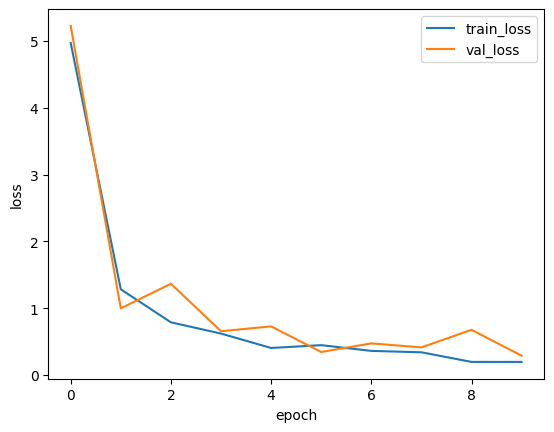

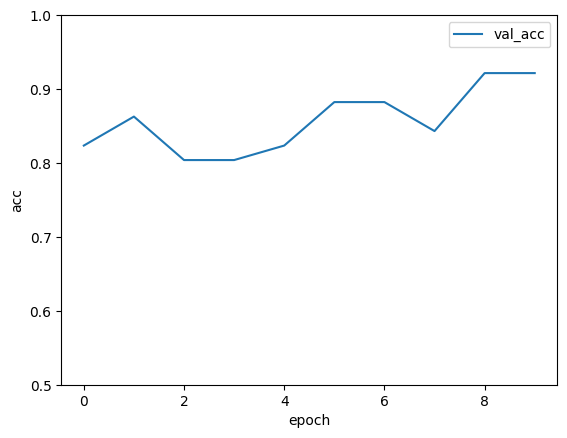

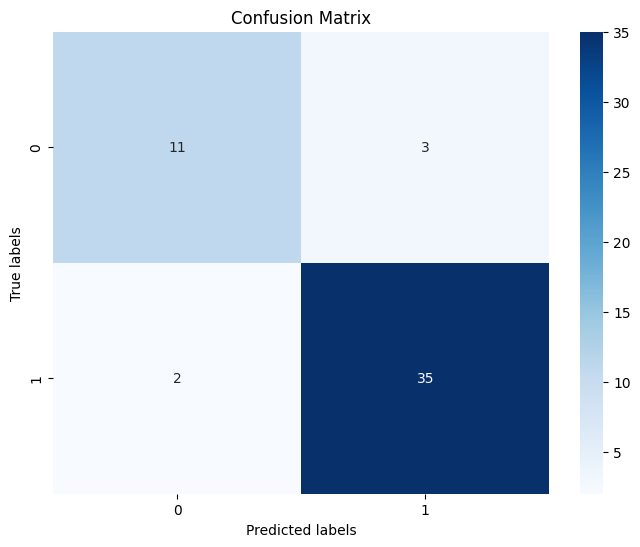

In [98]:
best_params_effnet={
    "learning_rate":0.0018406427797968729,
    "batch_size":4
}
exe_best_model(best_params_effnet,"efficientnet_b0",pretrained=True)

# Output prediction in CSV

In [ ]:
# best_model=timm.create_model("resnet34",pretrained=True,num_classes=2).to(config.device)
# _,__,pred=test(best_model,test_dataloader)

# final_output=pd.concat([pd.DataFrame(test["filepaths"]),pd.DataFrame(pred)],axis=1)
# final_output.rename(columns={0:"labels"},inplace=True)

# class_mapping_rev = {config.class_mapping[k] : k for k in config.class_mapping}

# final_output['labels'] = final_output['labels'].map(class_mapping_rev)

# final_output.to_csv('submission.csv', index=False)